In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )

loaded gammapy version: 1.0 
Supposed to be 1.0 (21-12-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset, Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    ExpCutoffPowerLawSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.maps import MapAxis
from gammapy.modeling.models.spectral import scale_plot_flux
from gammapy.estimators import FluxPointsEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

from Dataset_Creation import sys_dataset

## Read dataset

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : fb0Zh1Fo 

  Total counts                    : 596011 
  Total background counts         : 533641.19
  Total excess counts             : 62369.81

  Predicted counts                : 543678.62
  Predicted background counts     : 533641.14
  Predicted excess counts         : 10037.49

  Exposure min                    : 5.70e+01 m2 s
  Exposure max                    : 1.54e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 97420 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -2297944.15

  Number of models                : 4 
  Number of parameters            : 18
  Number of free parameters       : 8

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal m

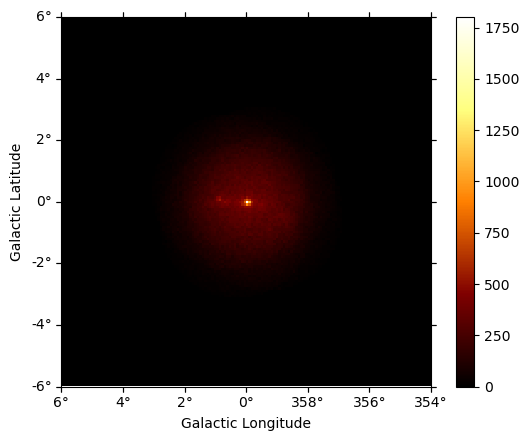

In [3]:
source = 'Galactic Centre'
path = 'C:/Users/yt02izug/Downloads'

dataset_standard = MapDataset.read(f'{path}/GC_fullsys/GC_fullsys.fits')
#dataset_standard = dataset_standard.downsample(4)
#models = Models.read(f"{path}/nuisance_summary/Eff_area/Galactic Centre/GC_model.yml")
models = Models.read(f"{path}/nuisance_summary/Eff_area/Galactic Centre/data/1_model_standard_best_fit_mask.yml")

diff = Map.read(f'{path}/diffusetemplate.fits')
new_geom = diff.geom.rename_axes(['energy'], ['energy_true'])
diff_new = Map.from_geom(geom = new_geom, data = diff.data, unit = diff.unit) 
temp = TemplateSpatialModel(diff_new, normalize=False, filename = f'{path}/diffusetemplate.fits')
diff = SkyModel(spatial_model=temp, name = 'diff', spectral_model = PowerLawNormSpectralModel())
models.append(diff)
bkg_model = FoVBackgroundModel(dataset_name=dataset_standard.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_standard.models = models

dataset_standard.models[0].parameters['lon_0'].frozen = True
dataset_standard.models[0].parameters['lat_0'].frozen = True
dataset_standard.models[1].parameters['lon_0'].frozen = True
dataset_standard.models[1].parameters['lat_0'].frozen = True
#dataset_standard.models[2].parameters['lon_0'].frozen = True
#dataset_standard.models[2].parameters['lat_0'].frozen = True

#create asimov dataset
dataset_asimov = dataset_standard.copy()
dataset_asimov.counts = dataset_standard.npred()
models = Models(dataset_standard.models.copy())
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_asimov.models = models


#Input Model for Comparison
dataset_input = dataset_standard.copy()
models_input = Models.read(f"{path}/nuisance_summary/Eff_area/Galactic Centre/GC_model.yml")
diff = Map.read(f'{path}/diffusetemplate.fits')
new_geom = diff.geom.rename_axes(['energy'], ['energy_true'])
diff_new = Map.from_geom(geom = new_geom, data = diff.data, unit = diff.unit) 
temp = TemplateSpatialModel(diff_new, normalize=False, filename = f'{path}/diffusetemplate.fits')
diff = SkyModel(spatial_model=temp, name = 'diff', spectral_model = PowerLawNormSpectralModel())
models_input.append(diff)
bkg_model = FoVBackgroundModel(dataset_name=dataset_input.name)
bkg_model.parameters['tilt'].frozen  = False
models_input.append(bkg_model)
dataset_input.models = models

#set mask to exclude J1745
j1745_coord = SkyCoord(358.6435538, -0.5617789, unit='deg',frame='galactic')
skyregion_1745 = RectangleSkyRegion(center=j1745_coord, width=1*u.deg,height=1*u.deg)#, angle = 108*u.deg)
geom = dataset_standard.counts.geom
mask_space = ~geom.region_mask([skyregion_1745])
dataset_standard.mask_fit = mask_space
dataset_asimov.mask_fit = mask_space

    
dataset_standard.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_standard.geoms["geom"].width[1] / dataset_standard.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_standard)

## Varying the Exposure

In [4]:
shift = 0.10 #+0.085
tilt = 0.015

N = 100 #831
sigma_a = shift
sigma_i = tilt

save = True
save_flux = True

In [5]:
%%time
for n in range(N):
    try:
        print(n)
        shift_rnd = np.random.normal(0, shift, 1)
        tilt_rnd = np.random.normal(0, tilt, 1)
        #print(f"shift:, {shift_rnd}, tilt: {tilt_rnd}" )
        sys_d_cor = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = shift_rnd, 
                        tilt = tilt_rnd,
                        rnd = True)
        dataset = sys_d_cor.create_dataset()
        fit_cor = Fit(store_trace=False)
        minuit_opts = {"tol": 0.001, "strategy": 2}
        fit_cor.backend = "minuit"
        fit_cor.optimize_opts = minuit_opts
        result_cor = fit_cor.run([dataset])


        if save:
            with open("data/7a_P_draw_info.txt", "a") as myfile:
                myfile.write(str(float(shift_rnd)) + '    '+ str(float(tilt_rnd)) + '    ' +  str(float(dataset.stat_sum())) + '\n')

        stri = ""
        for p in ['amplitude', 'index', 'lambda_', 'norm', 'tilt']:
            if p in ['norm', 'tilt']:
                stri += str(dataset.background_model.parameters[p].value)  + '   ' +  str(dataset.background_model.parameters[p].error)  + '   '
            else:
                stri += str(dataset.models.parameters[p].value)  + '   ' +  str(dataset.models.parameters[p].error)  + '   '
        #print(stri)
        if save:
            with open("data/7a_P_draw_par.txt", "a") as myfile:
                myfile.write(stri + '\n')


        mask = dataset.mask.data[:,60,60]

        ebins = dataset.counts.geom.axes[0].center[mask]
        fluxes = []
        for e in ebins:
            flux =  dataset.models[0].spectral_model(e)
            fluxes.append(flux.value)

        ff = str()
        for f in fluxes:
            ff += str(f) + "  "
        #print(ff)
        if save:
            with open("data/7a_P_draw_flux.txt", "a") as myfile:
                myfile.write( ff + '\n')


        energy_bounds = (ebins[0], ebins[-1] ) * u.TeV

        energy_min, energy_max = energy_bounds
        energy = MapAxis.from_energy_bounds(
            energy_min,
            energy_max,
            18,
        )

        fluxe2, _ = dataset.models[0].spectral_model._get_plot_flux(sed_type='dnde', energy=energy)
        fluxe2 = scale_plot_flux(fluxe2, energy_power=2)
        fluxe2 = fluxe2.quantity[:, 0, 0]
        fluxe2 = np.array(fluxe2)   
        ff = str()
        for f in fluxe2:
            ff += str(f) + "  "
        if save:
            with open("data/7a_P_draw_flux2e.txt", "a") as myfile:
                myfile.write( ff + '\n')

        energy_edges = dataset.geoms['geom'].axes[0].edges
        esti  = FluxPointsEstimator(energy_edges= energy_edges)
        fluxpoints = esti.run([dataset])
        if save_flux:
            fluxpoints.write(f'data/fluxpoints/6_fluxpoints_{shift_rnd[0]:.6}.fits')
    except:
        pass

0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.074475775773955 0.0641075212602296
norm 0.9444667703933589 0.054192398193864406
norm 0.9949499203824911 0.053442395348939464
norm 0.9418265024317136 0.05251258203992126
norm 1.0672369270359339 0.05806454766701168
norm 1.0294497874662745 0.061695217104342996
norm 1.0161735836486303 0.0690242727252528
norm 0.9007983707855343 0.07365100524693594
norm 1.0371669262578653 0.09265579632396098
norm 0.9318460410936562 0.10887594855502253
norm 1.110028834529743 0.14319479743652253
norm 0.9989248098008158 0.17449274685316887
norm 1.1909509430534426 0.2533856121617341
norm 0.7570971637293239 0.30957258257861686
norm 1.266361114700091 0.525043258512205
norm 0.5292032612737647 0.742003195065774
norm -0.6115174225135563 0.0963828560046083
norm -7.219922005479102 13.167204208943074
norm -535.1577036224668 339.7263214677997
norm -88152.54529850658 67297.87440793104
1


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0028806637932115 0.06174595963742481
norm 0.9700538991012368 0.054540102961814725
norm 0.9844090354892797 0.05313553730187321
norm 1.0727436612425896 0.0555297974060584
norm 0.9626325597279726 0.056808036041880595
norm 0.9954491853534694 0.06150720829575221
norm 1.0218028466338112 0.0687002787723219
norm 1.0120401881178949 0.07757406308629099
norm 1.0380739105593322 0.09198247161698528
norm 0.9294976499562544 0.10516687153950595
norm 1.0699264758871743 0.13859893361609021
norm 0.6838365891614617 0.14435810729603954
norm 0.9937376604754977 0.21496816505267755
norm 1.2079921370220057 0.31341822579232964
norm 1.2771364203468707 0.48639467159518635
norm 1.340155369176097 0.7572138804812294
norm 0.5763254825624695 0.9291993758945387
norm -4.8941879345339805 1.0675053208787522
norm 13.992036434733146 13.664432799959279
norm -61.1848860981728 36.700480427918855
2


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9694136065189146 0.06404322673838608
norm 0.967009065268441 0.05593739561589089
norm 1.0834781362912673 0.05558577424729639
norm 1.0256170238393791 0.05407492206818961
norm 0.9346525718291776 0.056173932890195455
norm 0.9237024535536298 0.06029874807557467
norm 1.1033324267155356 0.07009555606642781
norm 1.0112671446238317 0.0769927416895582
norm 0.9960879832952455 0.08861435680125303
norm 0.9151286039638331 0.1029923525570905
norm 1.1797297147056283 0.1411525250106239
norm 0.8532524676937436 0.16033205356937816
norm 0.8000150259757962 0.19382951888143213
norm 1.0041743732633015 0.3018234100603988
norm 1.3852898738962032 0.5077844067268741
norm 1.0683507527980045 0.7514127364938641
norm 2.2229924961441663 1.7946657423775658
norm -6.1883139620950445 4.182198948641814
norm -2.886776919883879 3.5891697432823726
norm -24.961373977888456 15.031240409402988
3


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.970893436207098 0.0624084827969135
norm 1.019275945452167 0.05555068560274677
norm 0.9368617158760811 0.05233167122225932
norm 1.0971729313705387 0.05553664120291075
norm 1.0290042786658076 0.057394010624061124
norm 0.9445713419712998 0.059483643816533635
norm 0.9751335808177014 0.06724178056765873
norm 1.0168628046847437 0.07778445377665383
norm 0.8670745019912588 0.08437070602394565
norm 1.1367385041964873 0.11332560606188713
norm 1.2605508762365694 0.14667115474557002
norm 0.8610699390593692 0.16096729302530016
norm 0.5607070801382913 0.17251571469627253
norm 1.0026985366400816 0.3030092355212473
norm 1.2426423243769322 0.46805912639951414
norm 1.129203118271118 0.7301785089598373
norm 0.4619385089365213 0.898274685453472
norm 9.14505579545485 5.842500928935235
norm -17.703393742865867 16.263166297917174
norm -11.012201128245021 7.646903788899102
4


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0015967616266603 0.06252419621155253
norm 0.9761513326342384 0.054995222204267113
norm 1.0345688631295789 0.05486944618571331
norm 1.025312661406752 0.05515659227731147
norm 0.9491931699043911 0.057146067504109374
norm 1.0115116887583664 0.06304269094025271
norm 0.9431510338253567 0.06871037582368691
norm 1.0747926489348185 0.08058067129723342
norm 0.9750562844690783 0.0905595051967714
norm 1.0394313744034764 0.10943425205581633
norm 0.9723569339839236 0.1330282751841535
norm 0.9798139267642133 0.1627548120036598
norm 0.943283398430187 0.19445205176071576
norm 1.0406659192906769 0.2729144690640023
norm 1.3777338208885495 0.42073093003606876
norm 0.4359933651342263 0.43307413280240875
norm 1.1157923941185681 0.8361129940412809
norm 0.551568357583487 1.2629261624902324
norm 3.4130784659062527 4.853434038647983
norm -468.0458263425125 784.9829515417312
5


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9845900342379351 0.06573686660985717
norm 1.0236496663337706 0.05749772730856605
norm 1.03037059150094 0.05623434619584458
norm 0.9259912307353886 0.05380017862960627
norm 1.0556396056826982 0.05952680219345272
norm 0.9325147416117553 0.05956933062424372
norm 0.9979731148243641 0.06866153651891817
norm 1.0390006863661891 0.07821133581748466
norm 1.1233200301724915 0.09271287750915942
norm 1.027431842235262 0.10757604517466741
norm 0.8749949776803174 0.12378075185718529
norm 0.8793043346937474 0.15702046933662617
norm 0.930606345728194 0.20264315797661261
norm 0.9931946548274694 0.30306055037663887
norm 0.947440527421649 0.41504916411517
norm 1.9729167637413871 0.9709813663804782
norm 1.4059871899794372 1.4472232122362445
norm 1.7547509316121537 3.7835009911900066
norm -94.16350738470094 276.9587246044961
norm 103.74881444788969 127.7258228374708
6


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9339022090471428 0.06016379738155073
norm 1.0687154679879882 0.05503813156857627
norm 0.9850447226525724 0.05274182811429212
norm 1.0254611767068609 0.053662315286014964
norm 0.9645388478148855 0.05618984687974833
norm 1.0013046056404613 0.061108826958818065
norm 1.0059147274001563 0.06856455694852283
norm 0.9973715125868498 0.07797808419693755
norm 1.0229100419221742 0.09154881087951011
norm 0.9625756906032623 0.10749682575809422
norm 1.089686273844474 0.14049243801364097
norm 0.7787817982575752 0.1524351445930777
norm 0.9988810575021745 0.22466202360616247
norm 1.2470310889536438 0.3276319066374825
norm 1.2006126797362542 0.45360929809641876
norm 1.1783689762315523 0.7346069668755469
norm -0.49148206135852357 1.883279849402626
norm 1.6726215942427098 2.9591869989517
norm -4.384892672558681 26.425760870050013
norm -803.2063389546248 840.3777306803323
7


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.026945958155147 0.06483019083469552
norm 1.0063258005966345 0.05583191457822262
norm 1.0318823347669979 0.054512037095861506
norm 0.9266882365483986 0.05311100694546757
norm 0.9799229961129576 0.057835051487369095
norm 1.0236833454924419 0.06231597339472017
norm 1.0054453678783433 0.06768962304619876
norm 1.0338053743452105 0.07693578568054071
norm 0.954288113088189 0.08831865281792745
norm 0.9432951376006077 0.10453697678055829
norm 0.9648093110402063 0.12900142421600086
norm 1.3041519575977767 0.17882862249563675
norm 1.061957092148053 0.20943342510417307
norm 0.9227629397188375 0.2785124173407524
norm 0.7433007664478741 0.36179521561749517
norm 0.8622460680568647 0.5341262818744134
norm 0.8804613943948454 0.9521837515045984
norm -0.6431641234930585 0.16161162748342844
norm -13.750218997029334 4.840973130009261
norm -4553.2935420179265 4575.905739680823
8


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0095697416602385 0.06440877558661987
norm 0.9729419832122501 0.055082687787850595
norm 1.013990697373392 0.05409706579463909
norm 0.9442205522435648 0.053616582305580286
norm 1.0622702142444846 0.05878814960709273
norm 1.036381444450208 0.06131279108017045
norm 0.9327481067006914 0.06635036212956384
norm 1.0496415162089028 0.07789581035049385
norm 1.0287866153037408 0.08913008679610666
norm 1.0993260329416485 0.11105171710366452
norm 0.9128916406051957 0.1239804985919532
norm 0.7282920955880503 0.1412567488175117
norm 0.7565706604664716 0.19112086277339652
norm 1.2356102058976206 0.3254121565021833
norm 1.3223435731546003 0.4642338580301889
norm 1.3186780240774456 0.7353732386568326
norm 3.401481830372506 1.9751413553227202
norm -5.10485565488353 2.0978921322912165
norm -26.501935842783077 61.350102522092044
norm 20.02881464615608 89.15118600023918
9


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9542903961997682 0.06125329495657137
norm 1.076362030838365 0.055058226665332055
norm 0.966423368936859 0.052019359227167127
norm 0.9535108995419229 0.05243881431848904
norm 1.018999773948844 0.05616681292876404
norm 1.0609815851841797 0.061414165522111874
norm 0.9617928721051419 0.06565823263496233
norm 1.0519532590587881 0.07835699858444728
norm 0.9517743168470314 0.08835749456014905
norm 0.9005901852147135 0.10647906709800646
norm 1.0115166791964254 0.14008203794174495
norm 1.0266152866738196 0.17848914921136383
norm 1.3623060204561872 0.2818971193732929
norm 0.708695214052205 0.29199937190777764
norm 1.227889670213823 0.6094047138168828
norm 1.0397928921297463 0.8247449335996747
norm -0.055922840991727146 1.5838601168539335
norm -16.410465528818186 5.860002768067029
norm -368.84208516444164 591.5835890094363
norm -6490.907640753039 2974.091192026974
10


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.005234582945193 0.06091035400196567
norm 0.987714297074758 0.0536429328431776
norm 1.0225331564711972 0.05294303367917364
norm 1.0090648807533138 0.05348279129058331
norm 0.9933856404151968 0.056771293328144325
norm 0.995518114771798 0.06188049955639171
norm 0.9081910574138246 0.06732447136273023
norm 1.0575833212796848 0.08053852135962895
norm 0.9436016279693652 0.09108687473056024
norm 1.158823851083766 0.11853758800639129
norm 1.0216616015015079 0.14453333934881338
norm 0.9895735390893405 0.17816366040185663
norm 0.8314612551219871 0.22475846328699567
norm 1.0226710345336627 0.343683744369325
norm 0.8602278710632651 0.4899424949924648
norm 1.9965683467720443 1.1148193232823826
norm -0.5939813811321373 0.30539544481538455
norm -8.778285236550166 2.182110172819103
norm -11.477135815161018 45.52271127093557
norm -465.48595250709457 304.53804197693313
11


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9703627105913042 0.06441119299274278
norm 1.0805491800100222 0.05713179172179034
norm 0.9457450898774159 0.053248462558312636
norm 0.9470315462744462 0.05280800523985541
norm 1.0290973481895407 0.057220691631768766
norm 1.0534941198337664 0.061882705682333075
norm 0.9881812311197957 0.0668632745682664
norm 0.9581449016004756 0.0755017898231251
norm 1.0795257433238739 0.09203084953068075
norm 0.985334434887081 0.10743309157327531
norm 1.051883985946827 0.14006013996403655
norm 0.7754447044580141 0.15845159021040486
norm 0.8704117178661882 0.22266421433984995
norm 0.8389568667793872 0.3087301341797417
norm 1.5590633901533186 0.5921578198748626
norm 2.23682263750223 1.2384052972750657
norm 1.3767570969364957 2.0436528647003063
norm -3.8597974798653576 1.569925920021225
norm -369.1620885820462 482.10355743988396
norm -503.1366028097493 1972.6820245585639
12


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9388430488477901 0.060947958957185064
norm 1.0214399932658265 0.05500622812147976
norm 1.0182747376269543 0.053204225123839405
norm 0.9997770776023114 0.054186977505477595
norm 1.080127913084857 0.05872376499623446
norm 0.9600558834880505 0.06037909506821222
norm 0.9886980920819917 0.0686757580700729
norm 0.8761312306300033 0.07376816589032238
norm 1.0581024275062154 0.09162160027031298
norm 1.0611078287953046 0.11015191633564939
norm 0.9782235671502839 0.13299208402902257
norm 1.0541665217346627 0.16703730941454834
norm 0.8875940501273345 0.2004383878916828
norm 0.7969459881917886 0.26689148261654905
norm 1.8204409569956257 0.5412399429547344
norm 0.5913161995809756 0.6754702215911182
norm -0.35744429695044205 0.10722377640691254
norm -4.612528667038036 1.688720072894363
norm 24.420554555303656 17.773641425801245
norm -7.16279146322074 21.639846000618366
13


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9583058019766292 0.05926788620822638
norm 1.0617249075974977 0.053591446870818495
norm 0.9742487012077503 0.0510604525396728
norm 1.010296497520756 0.0524288590210778
norm 0.9958752345318457 0.05573871821933719
norm 0.9860936424247024 0.05952730722776129
norm 1.0096254175613157 0.06727679894828283
norm 0.9835204967880748 0.07566372183467744
norm 0.9116874679622552 0.08566498489703314
norm 1.1912502858649916 0.11506722886217774
norm 0.9538430534152751 0.13052921087583794
norm 0.8572926577157768 0.15784158816612942
norm 1.0598383049813425 0.21482232399070011
norm 1.3508056058369802 0.3156594875560448
norm 0.8391470537380077 0.3893242751698127
norm 0.4570632263259758 0.42546551184460873
norm 0.7488432200206031 1.195371196316026
norm -0.588035750370357 0.18044649409952354
norm 11.86491621938138 11.23459089108958
norm -33.783142493968136 12.371872866569637
14


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0064813427484542 0.06296625741239541
norm 1.0454911879031499 0.056435569331057714
norm 0.9722881587610734 0.05373618827309227
norm 0.9943176903929948 0.054875235029949884
norm 0.9845213426475683 0.05691103585109378
norm 1.0313757481494932 0.06195318946060017
norm 0.8719184833356556 0.06504653804605871
norm 1.0414423795481151 0.07812372499089837
norm 1.074918550459564 0.09127492093001847
norm 0.9220431380018075 0.10307399648931564
norm 1.072210109531642 0.13122470410516543
norm 1.0461147094430074 0.15641989176313034
norm 1.171036577240168 0.20509186685478759
norm 0.9874353425268965 0.2583794030463041
norm 1.0347669552254528 0.34314611775900417
norm 0.6946310389126134 0.4648368315881413
norm 0.54510761155932 0.6445365592371002
norm -0.36852228229501033 0.08457070276328275
norm -0.8087779431378737 0.3423804136474051
norm -2.416546662600236 1.8164522480507392
15


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9629675945047823 0.06275956144885608
norm 1.0730026609697867 0.056489547109975946
norm 0.9384033777844174 0.05253955171212642
norm 0.9617659979699102 0.05360884391527325
norm 1.0544581889608928 0.05853036058955248
norm 1.0344283099927551 0.06273191862770583
norm 1.0228390660220987 0.0691065840813449
norm 0.9445642956130585 0.07656678115884087
norm 1.011600210993637 0.09113255382024565
norm 1.014164501826068 0.10852598502100666
norm 0.9879982908483971 0.13309265469376144
norm 0.9384910183747601 0.16210859974560501
norm 0.7347507602041261 0.19760721118422195
norm 1.1314865858224943 0.3151035864197846
norm 1.269663821455933 0.43133059356776116
norm 1.4618602323359173 0.775016229172817
norm 1.1956253662261922 1.219696730746077
norm -0.7684871198574553 0.293024950746315
norm -39.5294668268206 30.17615720888845
norm 23.514856184033476 86.18812173313754
16


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0031347552471932 0.06455961074623028
norm 1.0468861870769512 0.057040622233727134
norm 0.9306988632371913 0.05369880450933832
norm 0.9665069150919496 0.054866015724367785
norm 0.9744259048330312 0.05757002823023419
norm 1.1116830253030299 0.06463673321617652
norm 1.0642561297760291 0.07044739786016979
norm 0.9672680673262408 0.07679898081287113
norm 1.0732579527012127 0.09391839511663315
norm 0.7238881888057304 0.09472877688570523
norm 0.9729978952722761 0.13336978915012548
norm 1.0157425231057213 0.16578556564540917
norm 1.2029221489501092 0.2449889992633258
norm 1.0444123300961334 0.3037947309999954
norm 0.7409557475914512 0.3806174064964467
norm 2.2159490122557526 0.9569138967346167
norm -0.41882362512049454 0.10976767815905837
norm -0.5491131025851743 3.993579283787392
norm -74.5379785719544 195.57673978247635
norm -3191.424383168842 3349.0012169270417
17


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.967300591216881 0.06029707975085742
norm 1.0153799467602758 0.0537834090196428
norm 0.9855285453507425 0.05196743064113875
norm 1.1274254201292673 0.0554233117229406
norm 0.8587552306981939 0.05406608033556474
norm 0.9925675706694257 0.06058660826734979
norm 1.0643878043775892 0.06863476742811593
norm 1.0065420829323848 0.07595842175594741
norm 0.9404463392823785 0.08579673273552721
norm 0.9712827941463854 0.10417336971780251
norm 0.9351224217682865 0.12791444433434868
norm 1.2644367103762344 0.17677248082685135
norm 0.8937075923781083 0.1916086725856889
norm 0.8727672177248588 0.24862645170927752
norm 1.6666235457288257 0.46960980727993207
norm 0.5464712113374977 0.4908554568827788
norm -0.7088139575774672 1.6069821832215903
norm 2.4164413490526773 2.5617334812190364
norm -1.3488491705066956 0.45788283924911294
norm -4.516651987653269 5.136986549036807
18


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9863875654705649 0.059433020728273576
norm 1.0781773215124766 0.05351586894443297
norm 1.0010618492528154 0.05132450503698528
norm 0.8926820091075154 0.05009530573513447
norm 1.0235844253558402 0.055901825695578826
norm 0.9346290386496253 0.05794610441637071
norm 1.146725334723697 0.07011291388947279
norm 0.970735146517408 0.07577201202002193
norm 0.9118507134386951 0.08530106251413563
norm 1.052692647932555 0.109024574151838
norm 0.9748642307836657 0.12678570945823528
norm 1.1239953167116448 0.16908578779939576
norm 1.20116505172945 0.22189881240412473
norm 0.8369334697039396 0.252460102880698
norm 0.6853006959996867 0.38118521991316523
norm 0.9303179506996722 0.5529142903286609
norm 0.4990758391701302 1.161803471584597
norm 0.8679317762075309 2.0672605539994633
norm 3.9832047590460027 8.811444293760204
norm -32.039942407874456 12.50354090589383
19


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.031267129306929 0.058254166455329395
norm 1.0214068843245645 0.052352496185231516
norm 0.8961913803012725 0.04995239298528167
norm 1.0385342173799774 0.05335485495905401
norm 0.9979081027427504 0.05675956697688872
norm 1.032877471711116 0.06155201186477326
norm 0.9943228929208848 0.06868194482924057
norm 0.9447140300902558 0.07559813371534699
norm 1.0544179781758072 0.09224619656191088
norm 1.1367505856693998 0.11184247149913777
norm 1.0045887146475054 0.1295286377872445
norm 0.9460243229036668 0.15031696722291094
norm 0.8229639651436663 0.17758028647573526
norm 0.8945006727762187 0.2265716480765721
norm 0.8434542039102352 0.28572078448057175
norm 0.5212074611440873 0.3756832576193791
norm 2.1060933242468964 0.8733233583574549
norm 2.7430506472059464 1.5623089773248415
norm -4.7944419213296765 2.6173549019622566
norm 5.222307965929586 7.721620461918516
20


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0403005736722688 0.06260233726767109
norm 0.9345667577943874 0.053473352788488505
norm 1.0506390454967038 0.053285253654760924
norm 1.0176123960761818 0.053798295522135976
norm 0.9337677130953393 0.054866804285618
norm 1.081369704028356 0.06170928750562231
norm 0.8636490381750473 0.06353070285640854
norm 1.0747502641823172 0.07766127898536317
norm 1.0018599115104092 0.08895121049912907
norm 1.0316693727420527 0.10669916252621123
norm 0.8542112053287579 0.12372939759858305
norm 1.1090428431386157 0.17150228570811243
norm 1.156524999125866 0.22462775005332827
norm 1.1808392731764952 0.3277128374041855
norm 1.1294355042480702 0.4905751047291716
norm 0.23651404765693196 0.5784344365642202
norm -2.9644509614162367 4.743459391899929
norm 0.4309007062025897 4.792570590997712
norm -22.517107007074387 10.537220224390012
norm -4312.899703715821 3913.3488218905027
21


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0049810641383852 0.06257791822961055
norm 1.0162416486593195 0.05478904682109486
norm 0.9976626555433651 0.05265866290416497
norm 0.9565192064065757 0.05212310918281497
norm 0.9813993170829245 0.056324906304699454
norm 1.0396185921235535 0.061115774251501324
norm 1.0103212396771841 0.06783111390675155
norm 1.0617833316277694 0.07799493884322221
norm 0.9584035795486321 0.08828419975121617
norm 0.9926186910666721 0.10833368665378636
norm 0.9939985418876528 0.13833579027801624
norm 0.981281098628002 0.18031102723943274
norm 0.7673856359664125 0.22206987899003072
norm 0.8723752482847957 0.321467346711739
norm 2.1486686732758895 0.7262418979837759
norm 0.304342004070568 0.6743446741375281
norm 0.8235283359278418 1.5941286778262254
norm 4.21376966501001 6.126518995257079
norm -6.523734267242087 4.019157106656393
norm -442.6878651237489 353.13402960015674
22


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9769063341952284 0.060927067144799826
norm 1.0271085772603588 0.05500573754960743
norm 1.0264501495725442 0.053295603836989655
norm 0.9905583677767203 0.05405931546500884
norm 0.9821616748596714 0.05740433763261086
norm 0.9550751575904102 0.06143263186475554
norm 0.9636877576636963 0.068525473159646
norm 1.0552700902272605 0.07935423369365366
norm 1.0004635281924283 0.09252039553401548
norm 1.0820308646507772 0.11411576558029726
norm 0.9514272610714534 0.13523290836113722
norm 1.1417604511578168 0.18084373028275383
norm 1.0087996909729784 0.21941926781246215
norm 0.7781648474426431 0.2713125140316971
norm 0.851188992198232 0.39339597957396527
norm 0.49531648626001334 0.6267710137421688
norm -0.2897195850404253 1.3227092297555259
norm 6.6038252833664774 4.1405618644265925
norm -31.124397179781138 16.28991005949709
norm -77.77325332897013 66.44672603295714
23


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9973028852693481 0.0591584313345289
norm 1.0494301701826092 0.05295447457310531
norm 0.9775152307502981 0.05159331926671372
norm 0.9844839175836564 0.05289488818514623
norm 0.9314063781137752 0.05542979754051898
norm 1.0313527160335376 0.06180010094644929
norm 0.9253240442900625 0.06632567090083513
norm 1.1398404659818226 0.08074702798950201
norm 1.0814708977690008 0.09147616617382447
norm 0.9902783010774702 0.10659950940268531
norm 0.9021768022953717 0.12619919967070428
norm 0.9836131373361114 0.16121774254446636
norm 1.0418015064234192 0.19884783867660957
norm 0.8398058035931972 0.2441778434688993
norm 0.703173069547989 0.3021028758830459
norm 1.2740045564787685 0.515872442333522
norm 1.0831895258846627 0.7536813089021469
norm 0.9156022257049751 1.2056343100116629
norm 5.888332475373777 4.9898125671499
norm -309.4872661497769 147.9718160309961
24


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9576713225072585 0.06308000702304462
norm 0.9850522725164549 0.05462594253081759
norm 0.9415092493123469 0.051986579474151313
norm 1.1067637275638709 0.054725065331778476
norm 1.0254352194914487 0.05638544758242317
norm 1.0153624548781384 0.05959101076517006
norm 0.9587488338547722 0.06535838470240872
norm 1.0585177567215631 0.0771212443610132
norm 0.9870046646649864 0.08635396212185736
norm 0.9120825408905174 0.10249840346043966
norm 0.9551437474881314 0.1277089065941125
norm 0.7333239351145188 0.14342067809015613
norm 1.3258715901594662 0.23569722816436917
norm 0.7812593693830072 0.26531617586062545
norm 0.8631969182508518 0.39804358580598315
norm 1.6384575073972845 0.8443370451137497
norm 3.4662452409250015 2.025609521570701
norm 3.8834699428508004 4.279325782189199
norm -102.2592168714221 55.31910081116414
norm -1246.645555169814 993.5451965756334
25


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9857539389739798 0.06206281735608394
norm 0.9921954962158737 0.054350439321566274
norm 1.009487474223243 0.05327160450413103
norm 1.0292340025235407 0.05379259708710877
norm 1.0216345961673305 0.05690829648845488
norm 0.9266787430370245 0.05910408636117043
norm 1.0190584339748192 0.06780150865705338
norm 0.9328619500400523 0.07543135376570087
norm 1.0486698328246142 0.09151859640480543
norm 1.1571146135053139 0.11497830261703734
norm 1.0556455496658976 0.1402927152494538
norm 0.9373927692065234 0.16264574696235617
norm 0.6047892393609948 0.18423206591678185
norm 0.7658498465375804 0.2984413788384687
norm 0.9477935175966449 0.47560718127301327
norm 2.5396803351675628 1.1944872113144385
norm 3.300181880689875 2.35766581674075
norm -2.0988547250866945 5.905825227942488
norm 16.967416784103634 20.567918270930782
norm -129.43787884829925 95.90144351563656
26


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9555699264870495 0.061743458665404996
norm 1.005227361419461 0.054305465818976724
norm 1.0425866501722587 0.052955893193509476
norm 1.0015835406679818 0.05262293740614241
norm 1.0308012071282826 0.055651730060976005
norm 0.9674827254100812 0.058541543260521474
norm 0.9428338467664811 0.06426929720092883
norm 1.0063448349536324 0.0740458562391212
norm 1.0285066815976476 0.08674376236247998
norm 0.9441809661269933 0.10076251538778917
norm 1.0963638252838153 0.13672272292819326
norm 1.0507877105038013 0.16217665357735847
norm 1.0956386236464501 0.21787307276585308
norm 0.5612955903709386 0.24695973462411605
norm 1.2116251519417789 0.4959879178089821
norm 0.7843980459266039 0.6658539707768963
norm 1.4495074383783229 1.4335089949766133
norm 4.2165783977411815 6.649562995749734
norm 10.810583096460334 17.158127757786282
norm -877.8992483880259 1259.536683888221
27


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0128761900659153 0.06198821974363723
norm 0.9990675153754628 0.05457239468167373
norm 1.0036593897362407 0.052849157499996136
norm 0.9774950124524127 0.05308823115690486
norm 0.9463263969101586 0.05544986062188084
norm 1.0459317334106135 0.06120217413470813
norm 1.0497966155025187 0.06881901295513607
norm 1.0287067526898654 0.07688540386415929
norm 0.9995730303459799 0.08852373332870374
norm 1.0066991101878142 0.1062115891758353
norm 0.7752086757353074 0.11520107858308754
norm 1.1686160131987786 0.17067301699367654
norm 0.7541856084672793 0.18924875363214463
norm 1.046725132797826 0.2851904743769107
norm 1.6184235554043032 0.5167530177858556
norm 0.5805038880690052 0.6081118571263857
norm 2.1331964728316195 1.5313781962411979
norm -2.560541562640881 0.8756361171244816
norm -193.87150698168443 300.6934044439616
norm 8.701679408277396 71.26699416965474
28


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0374282373577515 0.06240450475150518
norm 1.0458448357948935 0.0556985558041312
norm 1.008415712194327 0.05482323230833051
norm 0.9024212042027284 0.05354937494880766
norm 0.9741261023569813 0.05875888532932716
norm 0.9923139258387557 0.06285264272495736
norm 1.0097905724644936 0.07095337150837758
norm 0.9321094446765429 0.07842167911771855
norm 1.192901488379475 0.098918008598548
norm 0.9877863217628982 0.10849638221521399
norm 0.8786490680520631 0.13083039137793748
norm 1.329671323661435 0.18142813910164726
norm 0.8266834333700369 0.1907550922088237
norm 0.7935232452305729 0.23326550379660357
norm 1.4406838231220183 0.40004317036150805
norm 0.3918466037075752 0.3058137971659189
norm 1.9594922391079774 1.0024918322406466
norm -1.0012600446879758 0.28499484254652857
norm -0.580652584133121 0.1942073438301549
norm -13.324572934523582 16.96393394649244
29


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9998138007481155 0.062383237747140836
norm 0.9890612867564899 0.054682813727318494
norm 0.995101884146385 0.05325153719081706
norm 0.9933619503879932 0.05292125090736839
norm 1.0002480937805456 0.05626119199131428
norm 1.0819225882418182 0.061723551873999596
norm 1.0292035397264763 0.06665677880774566
norm 0.8602731613581105 0.07126022885747132
norm 0.9739272856595571 0.0861470288136075
norm 1.0531884809488563 0.10739358107014017
norm 0.9948619480430726 0.13285081415112618
norm 0.9396260347370304 0.16345011681910557
norm 1.1035826781384226 0.22667826674748867
norm 1.3916713005475103 0.3441749238696113
norm 0.6562856810183227 0.44357790897265903
norm -0.5775528760079336 0.08279732491632505
norm 2.863536659322455 2.048838923998618
norm -5.291512537137379 16.163835643682063
norm 11.017953648345872 17.922570190207516
norm 139.76983630184742 151.01830873728704
30


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0871730853618486 0.06633432049246042
norm 0.9186570423996068 0.05637319165544743
norm 1.0086260702074843 0.05593414996626626
norm 1.0333037876043873 0.057241357682561556
norm 0.9715375182867277 0.05980088171541764
norm 0.950814693013643 0.06299039563122402
norm 1.0690531532945438 0.07295287527658104
norm 0.9364552611102867 0.0780489522584497
norm 0.9817651062997435 0.09204677714084257
norm 1.0543948260527822 0.11128794987025448
norm 1.0520768711280113 0.13652613035915148
norm 0.9737053468888912 0.16071353687648698
norm 1.4060286807970463 0.23387653812181478
norm 0.4645788088695703 0.20565930060598434
norm 1.1792958745478392 0.38619477908622707
norm 0.6171846956032428 0.4947736856766219
norm 0.9248267465908103 0.7724260958517427
norm 0.9385205119708839 1.322706493993809
norm 3.231926658502139 7.85909559908607
norm -436.1062210749103 183.01722285571495
31


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0362817137986975 0.06310068589520054
norm 0.9403802383717234 0.05402095747575504
norm 1.0453017829026976 0.05327899531017203
norm 0.9462857804190419 0.052179532957183215
norm 1.046775717424824 0.05712083279360682
norm 1.006264984394019 0.05998196111983685
norm 0.9313961297863345 0.0645960999087411
norm 1.1335845105021876 0.07870745649373531
norm 0.9052385210421112 0.08365646674056308
norm 1.078150370471191 0.1071847783528354
norm 0.9193603447926115 0.12738224037675971
norm 0.8519249275874263 0.15133896817577897
norm 1.0956549358456866 0.21819561074299193
norm 1.2513358044405358 0.3415931066713726
norm 0.7791861503155145 0.38960980128971584
norm 1.2132826445640552 0.7237830966504992
norm 1.3887373644412222 1.3764379681453092
norm -0.8620009798705072 0.1960380654851237
norm -158.88563840666092 175.49370924109616
norm 10.484448491171126 87.97782632253467


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


32
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9833218311432657 0.06242672019942102
norm 0.9964430812076084 0.054849445874421886
norm 0.9846346442296174 0.053599820291397614
norm 1.0679180230262628 0.055902495945962534
norm 0.8993556247336655 0.05549868369760303
norm 1.0100537990300118 0.06159906306431003
norm 1.099935874637302 0.07041212011336213
norm 1.063773875309581 0.07945260014878228
norm 0.8655958080516079 0.08412850965189449
norm 1.1924047850418404 0.11491334984559105
norm 0.857438139237401 0.1258652631267299
norm 0.678156717584731 0.13740708251915215
norm 1.146964259982383 0.2164895325641074
norm 0.8064281947338263 0.24478192515311745
norm 0.9649982344800174 0.3684943879869197
norm 1.7704226366248361 0.6848109701571184
norm 0.9754223234432303 0.8780229340661028
norm 2.302351524828872 2.1971117546155137
norm 2.820366445464916 4.893439959202483
norm 17.830194753974432 35.95522366785847
33


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9924309554370216 0.06163218245246062
norm 1.0388187488301202 0.054798137689285334
norm 0.9610743554533373 0.05230043270713473
norm 1.0732200505036849 0.054555796905323854
norm 0.9412298248439105 0.055857200918667596
norm 0.9977898263470534 0.060907976004462155
norm 0.9610567992441994 0.06631346394561279
norm 1.0030404280557648 0.07728922198241733
norm 0.906909158752157 0.08374455789021096
norm 1.0019684265554027 0.10560525221857976
norm 1.1548806664598241 0.13836319648149503
norm 1.115201742088206 0.17039437346081265
norm 1.305982934220276 0.23139898084457175
norm 1.1101160763938795 0.290750244652349
norm 0.10891478101329999 0.21342204402032558
norm 1.1133495317315192 0.6707192966193295
norm 0.39889912707404357 0.9430499661827351
norm -3.8260668303043266 2.7922703088296608
norm -1.36637168078949 4.115334510053326
norm -100.5288560049414 58.07823856181454
34


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.040389277483232 0.06281686920613995
norm 1.0205433720108195 0.05529894271073492
norm 0.9296874371216228 0.05225012404987216
norm 1.0016430792733937 0.053631785750527745
norm 0.974527245382022 0.056243756205121544
norm 1.0099364550541003 0.060692230573174355
norm 1.0466249849439366 0.06907368855305297
norm 1.070185414677649 0.07876719249054837
norm 0.9299806705708893 0.08701135133336813
norm 0.9500988360046694 0.10586908424602107
norm 1.028285135651833 0.13712273651454468
norm 1.137150761153889 0.1789826783849107
norm 0.9584537422019139 0.22423564476517016
norm 0.5994556566039092 0.2689947977557135
norm 0.7475932832090956 0.4097959659835554
norm 2.1831711174209283 1.02268991535239
norm 2.1114010019811906 2.058163560048315
norm -1.709371280777799 5.7961699042886625
norm -928.0303842447577 328.61299193072097
norm -208.42197908682508 263.84815987229456
35


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0388538173957937 0.065417277739066
norm 0.9766530255025241 0.05657002640632978
norm 0.9768229292451344 0.0548074950416988
norm 1.014437983107375 0.05564087423740998
norm 0.9567412547626262 0.05749974988824466
norm 1.0421998106310302 0.06299740011866307
norm 1.0370324852606514 0.07060141042723814
norm 0.9905597481696319 0.07831163892779706
norm 1.0306446388831476 0.09379272864333876
norm 0.9165601919119993 0.10542859758510775
norm 0.8687377683053857 0.12925503607845176
norm 1.152367651134888 0.1841249890248223
norm 1.0563297744299072 0.24056753815290344
norm 1.1279114642919328 0.3518994153251993
norm 1.037588492134848 0.47119825577845903
norm 0.2907462717723766 0.826270826006169
norm 0.04695422988970906 1.827114108124134
norm 2.30587125294291 5.028732553888736
norm -4.007447257723796 9.23978163362731
norm -125.00879632920746 210.8536470259878
36


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0511249931911484 0.06353518833546255
norm 1.0149660560604714 0.05534790781552294
norm 0.9479265609223865 0.052851622173584176
norm 0.952659543305557 0.05297859342303426
norm 1.0542739040103781 0.05775899143790984
norm 0.94864812965191 0.060021343766209545
norm 1.105827826249967 0.071185895647978
norm 0.9350980181753142 0.07665713891925956
norm 0.973293286364333 0.08985783185714753
norm 1.0057524169823642 0.1080689079132107
norm 0.9275992943598673 0.13140415443516443
norm 1.2733528932721918 0.18978741700971477
norm 1.0425439568046848 0.23562344751879183
norm 0.9842522996556167 0.3323858562368717
norm 0.8738779466654168 0.43278244155332335
norm 0.6087878752980811 0.6847910381083367
norm -1.094010472746219 0.18398254530861496
norm 2.3106116277285915 4.60029671464778
norm -28.589257120254135 7.950716463084164
norm -379.84871139443544 229.6431925255653
37


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9893180485471976 0.06157345215257661
norm 0.9470970540497425 0.05388168406128215
norm 0.9722173445868667 0.05268719740595513
norm 1.0973119763760528 0.05534618883472325
norm 0.9582543753320287 0.05662987042971573
norm 1.0606832827556791 0.06290091100216295
norm 1.0696976148999844 0.0702414553367146
norm 0.9965211340157211 0.07829900999198246
norm 0.9204122938074684 0.08869485852292076
norm 0.898257710158879 0.10544943514422146
norm 0.945792203545082 0.1358234876281253
norm 0.953073904526324 0.16615794819036145
norm 0.9394491841129065 0.21546111569587617
norm 0.6972456686931454 0.2897619063592362
norm 1.6585594442668177 0.5535009276549683
norm 2.0345344684568487 0.9666391939363745
norm 0.8307361588210008 1.7041919795162472
norm 2.842145825962703 3.749108484415812
norm -11.472575063354409 39.011729875335604
norm 9.241339843756162 92.27942440093874
38


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0174228514453507 0.06140096731939937
norm 0.9672686576945517 0.05389417915841389
norm 1.0014293221525206 0.05285620821167723
norm 1.0222403548664762 0.053355891744474866
norm 1.0275532057286938 0.05744143926430682
norm 0.9273435261860183 0.059347886785339934
norm 1.0200558429554676 0.06844470566621191
norm 0.9799235888825877 0.07686158358535461
norm 1.0869601340726525 0.09398910786817198
norm 1.0352993316192658 0.11005764863201165
norm 1.0277018163888407 0.13171637899207397
norm 0.8761103235407602 0.15438351111481916
norm 0.6706649952911194 0.1822663750960833
norm 1.1726047485753153 0.2963466814368112
norm 1.0230230526444049 0.4135834606792988
norm 1.8469455860859678 0.8089549888990873
norm 1.2383002674523689 1.5270898624163962
norm -1.4109241268410067 0.41266626905566633
norm -75.34635341096384 48.55092410437212
norm 53.28946568158835 73.28107549748214
39


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9558009428975853 0.05960435044235282
norm 0.9966443532170713 0.05374680224504514
norm 1.0684445057372762 0.05414434249589609
norm 0.9860949446906988 0.05340968962882045
norm 0.9607345660141127 0.05673154761314358
norm 1.0576824292258464 0.06336544155255065
norm 0.9986327306897297 0.06824066829675522
norm 0.9317702040945397 0.07622497885941804
norm 1.01835067176235 0.09044842335241714
norm 1.0223602000647924 0.1082605334563949
norm 0.9710093429773132 0.1332465646651669
norm 0.8761835422794931 0.14735480559562317
norm 0.9891620255971681 0.20520204768916167
norm 1.3801571846255378 0.30667098072773985
norm 0.9282061329979975 0.3707356066427683
norm 1.291671426778361 0.5954307269015701
norm 0.5626404278437389 0.6892797721610074
norm -0.42365840648329506 0.11185534444472396
norm 0.9178171778256955 7.176150933767101
norm -5.708009128807312 8.137366169764267
40


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0279572528586969 0.061734396003347014
norm 1.0080254829978743 0.05421524021047169
norm 0.9811261140192281 0.052083560607321534
norm 1.0001749479959499 0.05247215322988821
norm 0.9509649416180667 0.0548976839336531
norm 1.028520146253521 0.06006844094524704
norm 0.9632869904304645 0.06519196681780307
norm 1.0568819740301043 0.07623619021373558
norm 1.0291246105140783 0.0876463428109956
norm 1.0262668971361126 0.10435104190558797
norm 0.9086570226494433 0.12311164365285313
norm 0.8947069559279867 0.15005442217768392
norm 1.2006699933152343 0.22532558656508936
norm 0.9618890633690291 0.2877420609121538
norm 1.7018974915937302 0.5046475843042114
norm 0.42671070516526727 0.4997033754592089
norm -0.85260971414147 1.5687944514796224
norm -2.590205418300909 1.213109483281736
norm -17.549545499400082 8.775230002237416
norm -1253.4784688378984 1856.070806516125
41


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9788125448012167 0.06477896164488986
norm 1.0284617219426793 0.057506543777697795
norm 0.9864683580279182 0.054785709299450445
norm 1.0691956994143048 0.055490653695880736
norm 0.966594250378214 0.05745746841256069
norm 0.892303536330017 0.05868789925985292
norm 1.023586835957466 0.06822971802948792
norm 1.0672845189400388 0.07693775117913398
norm 0.9288666537992369 0.08297952713025472
norm 0.9896766433821583 0.10350656015871013
norm 1.1649736257397003 0.13714881882159874
norm 1.0733961040934668 0.15964939550601162
norm 0.9283425104355714 0.18903526736834655
norm 1.1189514173689412 0.2853072815729162
norm 0.8215085948439321 0.34668459748623703
norm 0.34376266970833835 0.39992814566464824
norm -0.04997095070874282 0.565747150666836
norm 4.159413605210636 3.234634448516666
norm 17.60583454679969 13.504584673778636
norm -1697.1010347099552 1040.500013762807
42


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0908300240505506 0.062411649870870424
norm 0.9395204058225299 0.053574510804581366
norm 0.9771175395616605 0.05326423306236983
norm 1.060432618302907 0.05530279194323936
norm 0.9519893153577756 0.057982184740121914
norm 0.9192911710187023 0.06096409831242156
norm 1.0010132024280856 0.07004168401838179
norm 1.076261426928214 0.0820501755626649
norm 0.9888268545817104 0.09345962537252187
norm 1.0372518279829033 0.1105714962366067
norm 1.0336049190062264 0.13515462418465657
norm 0.9664145648526181 0.16043031489925255
norm 1.2733615443377386 0.22388080724393267
norm 0.8311586218687302 0.2493496598458993
norm 0.8647970208002487 0.3455576639889089
norm 0.9434347806024649 0.5464888497290393
norm 1.0136638464270247 0.8825292732316069
norm 0.6250022476875163 1.2988810315507648
norm -9.59683016432132 4.4113511734544355
norm -424.7568683380317 209.73787668197022
43


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0112685163177568 0.061687610474889173
norm 0.9776729268510158 0.05447933288820115
norm 1.0028336206309876 0.05389651964101907
norm 0.996479253448804 0.05513921995156098
norm 1.0432319470324938 0.05983407938956077
norm 0.9816883486696878 0.06290091973822406
norm 0.9533823294724643 0.06928693237430587
norm 1.0117919629634944 0.08057818742328846
norm 1.0795782678845443 0.0954734570906772
norm 0.966882157489576 0.11048129901312374
norm 0.8189068961786253 0.1268097882000423
norm 1.2104455638590512 0.17818395061923775
norm 1.0900059601037821 0.2163421087897486
norm 0.5613090026233138 0.217085357213287
norm 1.3131347990557334 0.41024644599652227
norm 1.5329617844399024 0.6494034629528684
norm -0.2357071583469482 0.10892778564523303
norm 2.17585847082262 2.186016187116265
norm -2.757650751533938 1.745045923134627
norm -95.88924706741017 85.58989541934561
44


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9603424538700371 0.061169970970643445
norm 0.9908640713523066 0.05412222039451641
norm 0.9879426358521106 0.05281210013766455
norm 1.0760944782702002 0.0550669137434908
norm 0.9285729216571262 0.05592054260858388
norm 1.0457510216505383 0.06304495511039902
norm 1.0281722143361325 0.06955519990919996
norm 1.07866003360235 0.081058384305439
norm 1.0236632246391997 0.09451150483505576
norm 0.913421695008523 0.1062208299798624
norm 0.8231868874656687 0.13413328713265205
norm 0.5993319150357003 0.14523035588085872
norm 1.1416707922864155 0.24173897484439688
norm 1.1730185353949865 0.3487377892452787
norm 1.6444081617229056 0.6099480519546724
norm 1.481391258630738 0.9111603161816806
norm 1.9526665003909818 2.1147553791679488
norm 2.999119109821306 4.348010306855629
norm -8.59570421469211 4.213745203102101
norm -948.7492358463702 2468.0447130384946
45


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0959461590012107 0.06415252647466013
norm 0.9615362466850333 0.05441071388603994
norm 0.9617758902761484 0.05330889398530102
norm 0.9926966544383133 0.05385586765509043
norm 0.9908692707103826 0.05689154144728654
norm 1.0391395523162907 0.06234079567381373
norm 0.9366416509496776 0.0669185368941819
norm 0.9908811562643006 0.07639823012261915
norm 1.0509935857345958 0.09041038720544255
norm 1.01395176343166 0.10801533138105511
norm 1.1209476574039152 0.13530051644212474
norm 0.8064876303378892 0.1476720104932569
norm 1.0740306960391315 0.1976385140459184
norm 1.301186228908234 0.29274557855522443
norm 0.9659305207230637 0.359514517079613
norm 0.6775863170864571 0.42816761521610663
norm 0.3757411190516845 0.7765770029095971
norm -0.4326361956477804 0.21032670959091349
norm 3.414744785360094 5.347325227543866
norm -2004.7173499624919 1691.4407733282553
46


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9202478862042733 0.06196082809262967
norm 0.9622887483273302 0.054826662410080954
norm 1.0127461993861908 0.053768833771958825
norm 1.0737520171765085 0.05642891377423605
norm 1.0402940560533658 0.05868674557365453
norm 1.1149464194159333 0.06439480777295994
norm 0.8769241153363132 0.06583631084918497
norm 0.9599078520051728 0.07586457215353691
norm 1.0763516943114784 0.092116418633851
norm 0.9601116979699801 0.1059273160121403
norm 0.7831969589014557 0.11909606134746478
norm 0.9483183375917872 0.15687080619610905
norm 1.0978579997772042 0.21703269605447997
norm 0.8445392839352687 0.2431774398635791
norm 0.5692163839514853 0.32101770728193946
norm 2.8147534581027447 0.9038380891022033
norm 1.0305015127557635 0.9175690816790024
norm 2.5155059210812216 2.317494917855852
norm 4.197414419947339 8.082250427990612
norm -252.4153500692195 202.75040986200938
47


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.019054760470561 0.06228753902369259
norm 1.0455368821256688 0.0553682507862534
norm 0.9447562158976094 0.0523549677939041
norm 1.0559656381893854 0.05502806993056884
norm 0.9490269089585516 0.0564019987343948
norm 0.9585833897292912 0.06035742713432691
norm 0.9414001569584545 0.06826218842776226
norm 1.0657344060408038 0.08062557093237849
norm 0.9542820315124457 0.09299502413480992
norm 1.140276633572735 0.11856276756296638
norm 0.9280356933629642 0.1404990390030689
norm 1.2444806508449666 0.20005546990678869
norm 1.1597820487630972 0.2574343957562294
norm 0.8251690621983072 0.33112876969831867
norm 0.4340099821885459 0.3922742261417391
norm 0.2560168912022086 0.8291895841663127
norm 0.8560172502567821 3.1006879763103656
norm -108.97421581990915 24.513808319019446
norm -964.5554214238757 766.3191936445019
norm -2237.6778693708075 1506.5051206363314
48


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9687557479927726 0.06131778513596197
norm 0.9305107878383525 0.05338183676221022
norm 1.1379561352911112 0.05530179888315389
norm 1.0447358936247662 0.05433274317529857
norm 0.9008437700681602 0.0545643731971139
norm 0.9868369893255715 0.06071785407388318
norm 0.9997956227731314 0.0677595651116703
norm 0.9782234473805881 0.07632851501035562
norm 1.0118022669144238 0.0880213490057535
norm 1.001082981290074 0.10504867745857939
norm 1.1034579379439697 0.13345872910029463
norm 1.0567286066687087 0.16179272406902973
norm 0.6679019075670931 0.18331593187379994
norm 0.9669617953977208 0.2670232160551599
norm 1.543288438665288 0.45950844747652675
norm 1.02997650628289 0.5624547301319132
norm 0.8745702942964024 0.874708175606108
norm -12.923870742018245 3.6485271880835746
norm 5.432858638555156 8.049271619466841
norm -34.798142044042365 25.864093840960642
49


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0734967220809313 0.06383288640820348
norm 0.9360380808241235 0.053941235341893407
norm 1.0046764749093868 0.05336382548057629
norm 0.9785322765424763 0.05343639887584812
norm 1.0072764037760182 0.056665274573305585
norm 1.0312915678219665 0.06105616385649333
norm 0.9791335761553589 0.06643068968782095
norm 1.0625893266974271 0.07837846764146689
norm 0.8513411645805774 0.08315619492473329
norm 1.0551687670149474 0.10622289029867223
norm 1.0568928338386634 0.13413371906624194
norm 1.1867933324037891 0.17593104512517294
norm 0.8343917604887804 0.20040823118096776
norm 0.6870336337690672 0.2526612120399779
norm 1.354918729618407 0.5163849767174735
norm 1.5827861867096236 0.8632320217320745
norm -0.28638706256212454 1.1415969774201018
norm -0.9149546504817471 0.28478692272071215
norm -181.95139673212796 258.74539150679277
norm -200.8039568162934 102.0850506942282
50


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9384222818444677 0.05869543239450697
norm 1.0434342213701613 0.05334603636700194
norm 1.0519136126908444 0.05216408035232557
norm 0.9831347974631213 0.05249641522436882
norm 0.9793565758244847 0.055789069537889806
norm 0.9918024688591625 0.05954356633475218
norm 0.9411950168500501 0.06575130227274993
norm 1.040298818538038 0.07729735548789085
norm 1.0745879971198586 0.0933279429344531
norm 0.9317518166405567 0.1036405654900737
norm 0.862971223212715 0.127967117420493
norm 0.859363397231334 0.15900048075197162
norm 1.736564592468933 0.2713293075658547
norm 1.0138983393982663 0.3095631110956192
norm 0.6825746380003672 0.37685940860392936
norm 0.4925139523953702 0.5409519173159614
norm -2.714899126575412 0.5106232225078694
norm 2.722446026450834 3.504809552221058
norm -2.385357042310969 0.7762249155941289
norm -80.40297127511771 149.51743073020543
51


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9812278903970924 0.06352693638524519
norm 0.9851958386307578 0.05583820193645814
norm 1.0552609914093647 0.05503209866878224
norm 1.0081240553514024 0.054123955860452835
norm 0.9559877512890395 0.0566519002766851
norm 1.009371961178528 0.061012733402138496
norm 0.9668457910684661 0.06676858871156265
norm 0.9713146701638042 0.07664682693077259
norm 1.0939817308831643 0.09391940914795635
norm 1.0657278856742738 0.11183155640059689
norm 0.8646964981271413 0.1314864251781292
norm 0.9784889723910878 0.17102786774456613
norm 0.9823453138007029 0.2309621149038242
norm 1.1707492153320982 0.3581912464305303
norm 0.6820949298496851 0.42172996505773025
norm 1.7286146057674578 1.077223953049516
norm 1.7901678736634998 2.5222076661709103
norm -31.431514727304926 7.36022282745966
norm 16.780206700357656 39.443783562474536
norm -2432.4934163632593 2765.532829601135
52


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9503208903612937 0.05830609593838246
norm 1.0309448316802559 0.052569950921888625
norm 0.931087961651431 0.050682365430759
norm 1.0833852675432405 0.05350472285033216
norm 0.9985712893647075 0.0555886534413134
norm 1.0448383030546742 0.06042883641567172
norm 1.0199491479837948 0.06741010424505253
norm 0.9371672161455699 0.07428880165133663
norm 0.9977199396128806 0.08815536802997125
norm 0.8782412126846543 0.10067461295066153
norm 0.978828044168236 0.1300865197964357
norm 1.0858473055854236 0.1663180849519354
norm 1.2159547624739409 0.21994278707433387
norm 0.655463256838059 0.22323242868277346
norm 0.7543401617515633 0.36294395883075375
norm 0.9816000330422952 0.5585668856773617
norm 2.9733714034657264 1.4443799651221012
norm 0.9918237816046646 1.4822475142188574
norm -1.156505983489043 1.8548546543044657
norm 29.953842374555418 37.53816172136518
53


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9312939181826732 0.06412931907690621
norm 1.0762441221917853 0.05732062049395833
norm 0.979220641070502 0.053541176676125346
norm 1.0347329038405377 0.054751669792378374
norm 1.0066780327283396 0.05706860793983775
norm 0.9804442632711818 0.05982378885881547
norm 0.9242428195119136 0.0646321839011704
norm 1.000211050961484 0.07402714431401725
norm 0.9853581071199408 0.08568166246357228
norm 1.0072351478221129 0.10392620888708318
norm 1.156830132971481 0.13713310088725886
norm 0.9648847920559289 0.15772431012963778
norm 1.1147490930105755 0.21300698716207958
norm 0.8534370057478475 0.2885263523253095
norm 1.2366467955720788 0.40984827069531043
norm 0.28477021602482644 0.4603904349301489
norm 0.7789208108845647 0.9804270675751304
norm -2.989593869545405 10.996536496190169
norm -2.049940029346865 1.071597026229807
norm 31.347013367942786 83.28000412157891
54


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9433499929631602 0.062375079494526656
norm 1.0469588404230703 0.05572959621074406
norm 1.0126485539090033 0.053695752236940016
norm 0.9897190991720056 0.05409747037632048
norm 0.9517318190518836 0.055860628457837194
norm 1.014744456825722 0.06126103293975308
norm 1.0954788294392936 0.0695008952395449
norm 1.01282928586512 0.07604705205258666
norm 0.9105543910281251 0.08286659157149019
norm 0.8554727087291454 0.09828376261376442
norm 1.2250907437854348 0.14128238921232056
norm 1.0368322438911772 0.15856900618836356
norm 0.8369282967330386 0.1869658658354242
norm 1.017657228471435 0.26249557560776826
norm 0.6049838852714209 0.32692400567186164
norm 0.8539533001214072 0.534722506132919
norm 3.4973958530548965 1.4359711326849545
norm -1.689512537499684 2.0246422088437814
norm -134.41890406508932 102.51733466561414
norm -13.720640942476331 28.377523917941886
55


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9670733529370436 0.05974649624590079
norm 0.955449473454175 0.052219236439206056
norm 1.0744841615642773 0.05256067295507037
norm 0.9806225387171607 0.051359867612585874
norm 1.0777473428762196 0.05663371293169183
norm 1.000324768569998 0.0585532915782242
norm 0.9409245171441833 0.06389085983851718
norm 0.9570104306438593 0.07299132621458083
norm 0.9511803223248199 0.0830375213037591
norm 0.9708680228176142 0.0998788405267981
norm 1.1532034523204986 0.13684493203868395
norm 0.9941814655186613 0.15932264978250563
norm 1.0617945985145611 0.20722532064138002
norm 1.131250871518716 0.2987854530765088
norm 0.5614954378963312 0.38524939308369655
norm 0.3140639653330877 0.428057905494385
norm 2.2338807446751257 1.4277219061181503
norm 2.3312073826477615 2.9790568934868524
norm -18.527895354987407 7.655346074133632
norm 16.677792895583323 77.6474300346917
56


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9938032054764655 0.0644779292177229
norm 1.0164902846299433 0.05603824638737804
norm 0.9312274619189868 0.052894052403441603
norm 1.038368544526923 0.055150442057168944
norm 1.002596039893705 0.05715172188424888
norm 1.0203410337672123 0.060936133674974205
norm 1.067852408429697 0.06816453267608154
norm 1.0066768483089985 0.07514957891475323
norm 0.8452122448157855 0.08060936765840646
norm 1.0617255666731213 0.10563165118969255
norm 1.0001763211103927 0.127351817006126
norm 1.031067371477953 0.15839020943885712
norm 0.8893065051348994 0.1866740852222592
norm 0.9789472924307627 0.2644318666276671
norm 0.8902323482677881 0.35474696388523963
norm 1.6278351551653518 0.7564934179363023
norm 1.1147710441000895 1.002353709248081
norm -0.6326190100642576 1.065107782471094
norm 20.644845483079564 15.768876023092927
norm -248.0629634892143 169.04156636210783
57


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9741786026880178 0.06142394555859134
norm 1.0031315489394539 0.054053410184494055
norm 1.0332760780510422 0.053133299533718974
norm 0.9985664378422343 0.05308111406166678
norm 0.9904331819437132 0.056717810551216316
norm 0.9497263954407559 0.059505045756054566
norm 1.0378405069341212 0.06851262509357159
norm 1.051209511492185 0.07940868665939158
norm 0.968698232582106 0.08833451700469606
norm 0.9996879490329821 0.10911225518227098
norm 0.9768370421550762 0.13603240546566614
norm 0.90095587468596 0.16408682300875618
norm 1.0335312781639676 0.23119023033982336
norm 1.0983543474019355 0.33634042768079536
norm 1.3021078173329073 0.5366554003383307
norm 0.735094317372082 0.6732072616804434
norm 1.4647565658605677 1.8302948538750914
norm -14.02203221291633 20.001160933782476
norm -101.8570744529957 84.1112646864251
norm 281.66229954506287 214.2942272955128
58


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0610719989183681 0.06341146272802242
norm 1.0009950962680176 0.05509236993017002
norm 0.9508150740350969 0.05212913578392352
norm 1.05235323598209 0.05401205689235575
norm 0.9802747475194571 0.056244749018581675
norm 0.9322717983785813 0.05835063881896767
norm 0.9425260418494615 0.0644213233927969
norm 1.0225104662692297 0.07385898733061663
norm 1.0967075394827295 0.08750364226100793
norm 1.0089521922360076 0.09993770144896048
norm 0.9568875065148389 0.11971136588621374
norm 0.9665686125586349 0.14641578234328492
norm 1.3103967887198407 0.20777114067513427
norm 1.0870708235903916 0.2539293819049419
norm 1.0143361069805485 0.32775166891449115
norm 0.6149085242333906 0.37663342056145105
norm 0.4822898782696811 0.7833308341652955
norm -0.007558820706184025 1.0121541295458236
norm -8.537704981736823 17.412223296254947
norm -27.532571551880682 19.28802537912223
59


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0285626706025832 0.06024157859754641
norm 1.006054479587608 0.0535823662051184
norm 0.9869832615829375 0.05187304910083047
norm 1.0166382820790154 0.05361153143735086
norm 1.0069246437483184 0.05749250353492745
norm 0.9996621323594516 0.061389352618493986
norm 0.8608549367915402 0.06497462957073354
norm 0.9802805847418689 0.07728759727531964
norm 0.9588908698750418 0.08916605011624149
norm 1.1440596648254788 0.11280764728410235
norm 1.1964551582943592 0.14243899967784152
norm 1.1327024462784807 0.17823603733606705
norm 1.090941344649252 0.22364074257226974
norm 0.9071150566081595 0.2901505290081249
norm 0.5605196726835049 0.31270322488125724
norm 0.11556584382039832 0.4328189278220472
norm 0.27011155199393355 0.8637444936204347
norm 2.3475950230916225 2.775349375936558
norm 13.312584922626394 12.184894894730986
norm -324.9409941123916 203.95565349788515
60


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.8894296985555945 0.05775874977096586
norm 1.028315492172091 0.05369583412378273
norm 1.0277664375575681 0.052816586670117856
norm 1.05116276055914 0.0542690680412813
norm 1.0328058907392268 0.057695926011376374
norm 0.9987777815472711 0.0616130494579169
norm 1.0085415470192975 0.07042674555530136
norm 0.9315021861729049 0.07648720292332734
norm 0.9006393152041465 0.08763272579227666
norm 1.0611524366318603 0.11235247457629767
norm 1.1497669121847518 0.14600730377215543
norm 0.6684538882011887 0.13896937496741024
norm 1.0591172263004516 0.21465328989789337
norm 1.0926679153587189 0.2904338958996854
norm 0.9940636551386669 0.40821604993126653
norm 1.509130111036639 0.7148234623181796
norm 0.9894656285561998 0.8588341550663641
norm 1.9118968842200068 2.0858555516587653
norm 1.159549698023895 8.194908582823103
norm -623.0920785573669 327.2170544466793
61


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9860351053961075 0.06104349280237023
norm 1.0143695547561826 0.05515823518303879
norm 0.9809063988817246 0.05169541439220494
norm 1.0182467223469918 0.05269625070592929
norm 1.0049175552038845 0.05599936593932876
norm 0.9641622590422837 0.05857053338371974
norm 1.0513420980379016 0.06674038625423694
norm 1.0114703902485978 0.07500142684568674
norm 1.0284538541259127 0.08748520633719968
norm 0.7800643021956365 0.09450142480693846
norm 1.1798902051192686 0.14120813610158642
norm 1.000627181948125 0.1664884879979775
norm 0.954781190468346 0.21550027509345357
norm 1.0205321337196385 0.32057707475636765
norm 1.1442490735108382 0.45763893527313926
norm 0.4806949860802358 0.5378088968676695
norm 3.55006038253589 2.52070804038503
norm -52.0729741103729 59.03402147983938
norm -73.0857380916628 24.311827528766656
norm 109.17527683462207 165.49205880888277
62


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0880003951235202 0.06741916720292124
norm 0.9074045669155003 0.05655965460721795
norm 1.1012446834914755 0.057476758118995476
norm 0.9167647690000605 0.055037449330502315
norm 1.028005358939461 0.06015526274205941
norm 0.9229156476243051 0.061663606106460725
norm 0.9829699600459253 0.07022086041873865
norm 1.0195560800879584 0.07954506140274252
norm 1.0946553999662225 0.09385149481686253
norm 1.0369631854453467 0.10902646313802751
norm 0.8437740092761162 0.12265599572975451
norm 1.3094668085651155 0.17855985989565273
norm 0.9125852434783812 0.19970618911291838
norm 0.8497571250598085 0.26677599932428847
norm 0.7495869922530598 0.33211885710284217
norm 0.893917818328698 0.6180984172174029
norm 2.750406455254286 1.4437021796056901
norm -10.41398993783848 17.155729944575793
norm -15.661440192959274 6.505682309382933
norm -856.7191521721842 1138.1883523299562
63


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9899254163200665 0.061694990280729514
norm 1.0210479126031902 0.05460913688929305
norm 0.9285661148351364 0.05298508863114694
norm 1.0445830200283432 0.05466030772232373
norm 1.0495591113355023 0.05820499114895234
norm 1.0038623996804574 0.061291918796912925
norm 0.9666685388309988 0.0677064575233169
norm 0.9655649528153745 0.0754705394811959
norm 1.003152544107862 0.08934639743448164
norm 0.9939208308434534 0.10754768020935779
norm 1.0649854450775391 0.13476791411750466
norm 0.7587429310054458 0.1491682090398451
norm 1.3266011080967932 0.2357157190296445
norm 0.9046215062637376 0.2691582698443525
norm 0.9121914619814886 0.3891715812845893
norm 1.8428443169664845 0.7515206327801373
norm -1.3982842636176527 2.842482726194905
norm -18.205088667622906 29.994528575687045
norm 5.983091421184382 7.449181689045786
norm -17.19607738469123 9.853621452584745
64


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.09243923280939 0.06276372385116846
norm 0.9096478917611897 0.05254069785257185
norm 1.058189363597325 0.05367495600158617
norm 0.9588956870178608 0.05279290057620455
norm 0.9955858494493236 0.05642890352581363
norm 1.0051062135681015 0.060750916959647246
norm 0.9423851192768585 0.06736727308019179
norm 0.9529526427051438 0.07600839550396545
norm 1.0492373016757865 0.09155763345983983
norm 1.2209514437457973 0.1187534211719039
norm 1.0535018324686594 0.13959136638754174
norm 0.8088553361950346 0.16691296112564735
norm 1.1013662320880921 0.24592505391442435
norm 0.7329385950599782 0.2917577915937411
norm 0.9133227502847024 0.5122012141008265
norm 0.5786509985517033 0.6153073418836568
norm 1.062584601911749 1.5023848138392366
norm 6.213861162222928 6.444499608015819
norm 26.14477688482334 34.28671478523707
norm -16885.93529528794 21898.932813779105
65


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9778314940111433 0.06191999645117942
norm 1.0116153849019884 0.05467554528674486
norm 1.0454156470726799 0.05422312412677024
norm 0.9677753371496461 0.05313409670313407
norm 0.9583832061356877 0.056800609190033394
norm 1.0159315427069127 0.061242869871169024
norm 1.009016876184581 0.06949228210257107
norm 1.0356487041408289 0.07815595557851987
norm 1.009201474076791 0.09000612165679278
norm 0.9480482628252783 0.10456767501283719
norm 1.1122860356474757 0.13764138579067065
norm 0.883723351453117 0.15509638189404315
norm 0.8163342068553454 0.1827213197219496
norm 1.1804748652055408 0.3120803020631591
norm 0.9443273233672635 0.3878851000451973
norm 1.5203616648848106 0.6714080271707522
norm 1.760796650423556 1.3569974706348966
norm -9.50939229559071 8.514032704678435
norm -3.756546251900431 1.7939856233363145
norm 22.295365600314412 44.88149484394327
66


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9532376293031547 0.06063725016977386
norm 1.0886221412977448 0.05538923031655211
norm 0.9087621786022307 0.051682902475725864
norm 0.9319315794847846 0.05255185842147776
norm 1.1614077256732607 0.06079257923679577
norm 0.9719589926774717 0.0601786905773511
norm 1.0418867679202644 0.0688920841594118
norm 1.0295910466054643 0.07787594257658302
norm 0.9420842592645424 0.08677835803288239
norm 0.955550873515864 0.10359180118732461
norm 0.8960927539976047 0.12671353207374572
norm 0.7965353798829478 0.15058417827533868
norm 1.2198437557531776 0.23526751288937686
norm 1.1806177288793442 0.31278646370473234
norm 1.3598830702064382 0.454774453975545
norm 0.5863527716020802 0.46701588332358673
norm 0.9504937712340997 0.8663474774877715
norm 0.13528266889985424 2.720699666981873
norm 7.602055718849886 8.540065419624147
norm -1362.491566102652 789.0142845569713
67


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.060792135398526 0.06781799654416511
norm 0.9705522265555289 0.056938168440737215
norm 1.0131588175458466 0.054313250871823385
norm 1.0635018789508857 0.055051262796573165
norm 0.9264165423508162 0.055680520525081406
norm 0.9096789656728315 0.05807645190737546
norm 0.9647079542989715 0.06473559876507141
norm 0.9790507365410798 0.07208457648210857
norm 1.0777051496283598 0.0878277169900676
norm 1.242819913993009 0.11321090546049795
norm 0.8688245847157627 0.12409693322878
norm 1.3729189148745915 0.18929459113584593
norm 0.5775727378249689 0.18543238582144905
norm 1.029573967889102 0.3108835876202138
norm 0.5864814670158452 0.4688052051068057
norm 0.4803982799326208 0.5837722065637219
norm 0.8027836866266812 2.115856187155935
norm -11.779585071524032 4.997785739842869
norm -744.3935162180857 342.1382422390943
norm -2119.8828732309785 1145.4505404662905
68


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9252882587761964 0.06040669270586812
norm 1.0795070744040436 0.05536585907459376
norm 0.9897977866181308 0.0526385393373364
norm 0.94566661719058 0.0522322946199385
norm 1.0508600231669796 0.05724893421206539
norm 1.057474794970689 0.06175774912777961
norm 0.958053386213845 0.06614595001610543
norm 0.9744053774624944 0.07625967168349553
norm 1.0106376108149868 0.09146289010595304
norm 0.8995014112914104 0.10551965530619774
norm 0.9717475145327822 0.13568493222122474
norm 1.1083186372448721 0.1793719276847127
norm 0.9682682811745733 0.21863817447402767
norm 1.4174490686630534 0.37910798364083254
norm 1.066550656300822 0.5109531338007824
norm -0.21004344826732943 0.7631471021161065
norm -0.5765463142536894 0.20568357336744608
norm 3.3392430539841813 5.3411632829552556
norm -3.978228576265778 1.392014467451227
norm -2637.4355104434094 4869.0210656387135
69


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0784191546479613 0.06203732792278599
norm 0.959792592693003 0.053457323928124856
norm 1.0361352260315857 0.05306595622812597
norm 0.9567610423278123 0.052749292968463056
norm 0.9380301296917251 0.055515393317683265
norm 1.0662198766350188 0.0625398765580184
norm 0.8895492966707131 0.06468381057976319
norm 1.0773296326716362 0.07950252184484226
norm 0.9151809638953354 0.08623342865258174
norm 1.1813351645144778 0.11309327427870518
norm 1.0017564065525182 0.13053725742080582
norm 1.0949453697259557 0.1671974943904078
norm 0.953588095853196 0.19807041075956444
norm 0.8872560391741776 0.25238560433129914
norm 1.100712144223035 0.3987807818028014
norm 1.719140690539023 0.7008625295982984
norm -2.157891710424598 0.28435477308887125
norm -1.677396676358846 4.568380398598507
norm -6.326118965158376 1.720638255957763
norm -716.5988664902018 569.4355893563012
70


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9691629367171356 0.05998811185851458
norm 0.9940807421966975 0.05334330093444336
norm 1.0418625086271187 0.05279373505525286
norm 0.981897518451962 0.05244280595814417
norm 1.008630234320336 0.056190617269331396
norm 0.9671840677148247 0.06013353052324123
norm 1.1194611259795668 0.07005836280584979
norm 0.9322438562639772 0.07486481996407428
norm 0.9597599769924179 0.08704042639827227
norm 0.9655101992806204 0.10768661529680487
norm 0.9580985911724647 0.1337035783353504
norm 0.9043755225154538 0.15715830518756863
norm 1.2510527795960389 0.23937578702377418
norm 1.0062615922554448 0.3016849424944037
norm 1.2809201082624375 0.4708434042288573
norm 0.9238469393974733 0.7006233711171306
norm -0.43450158890700247 0.1866606818080786
norm -1.7671528341967233 5.7411106838269195
norm -2.5314247779082275 2.657221297269089
norm -409.88716807997565 298.4145790301817
71


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.954262275864717 0.05952172194191074
norm 1.0796141987346461 0.05421079860634066
norm 0.9565246072289019 0.05109319654341348
norm 1.046082116317754 0.05325307875748348
norm 0.9462699757253088 0.05441695614132858
norm 0.9361752835245403 0.057970506574833255
norm 1.0720993147255333 0.06778426377523657
norm 1.065726298701341 0.07661108688381518
norm 0.941601036403119 0.08374879530361218
norm 0.8923558218147989 0.09816585895460149
norm 1.1225292547536294 0.13225260087402216
norm 1.0933119642408242 0.15712047213616268
norm 0.9342586677903432 0.18984647778351027
norm 0.8629352920694168 0.23130761108716524
norm 1.2519104762410145 0.37646665582820515
norm 0.935250476794791 0.5914005977480772
norm 0.6667422830728588 0.9719929985917413
norm 0.8023423986763194 1.191219849723178
norm -0.7028370564131927 4.808108368170823
norm -81.0657687508305 58.785921014227625
72


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0153268567358802 0.06358361805318555
norm 0.98547437377657 0.05584921938221853
norm 1.0211039555501058 0.05493613040900958
norm 0.8958861802087607 0.05331643164947928
norm 1.0559424026012336 0.05874276957732531
norm 1.0413299973478336 0.06329833327035805
norm 1.0672651338546904 0.07064486112796645
norm 1.0128370715177926 0.07723980361839625
norm 0.8944406463719414 0.08489387352536924
norm 0.8871402961849617 0.10347377478997562
norm 1.0996656670265976 0.13288183988145078
norm 1.1694265578353027 0.17043469675115389
norm 1.0374589100925975 0.20695981891582296
norm 0.34372048982091524 0.1632221796823858
norm 1.4837753509330704 0.42183168817338434
norm 0.9834177756675719 0.5283529990682936
norm -0.2346913862692285 0.04172576973570695
norm 2.237621112139494 1.8702076004670682
norm 6.546007480040368 6.3954653588841985
norm 29.084924797451183 31.61332856599838
73


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9327459051385251 0.059645424714419894
norm 1.040831320587939 0.054369122561304946
norm 0.9983367408168178 0.05257603654460952
norm 1.017391183216111 0.054339773688056175
norm 1.0484349571235325 0.05852450338491848
norm 0.9520344793044662 0.060256511226011576
norm 1.0167810997971336 0.06922182618519182
norm 0.9776292089710437 0.07708412410944998
norm 0.9542142275044467 0.09058003720857369
norm 1.0371763834616488 0.10931329420600613
norm 1.0115162512219469 0.1322941139958968
norm 1.058722618432558 0.16486508639333858
norm 0.7277866540961802 0.17684732742960643
norm 0.9526721173094661 0.26061049143275905
norm 1.3705066013150242 0.4237411330492418
norm 1.5393981523958586 0.6351727768368045
norm 0.11333950520293294 0.6057116085787296
norm 2.048556585540883 2.1537565429929098
norm -13.206565806669222 10.230312070153712
norm -5.926749609700584 3.7914061193391553
74


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.934582047008887 0.06187657590234356
norm 1.0409448824223457 0.055544919661481736
norm 1.02169157764485 0.05350676719079679
norm 1.0531191552784085 0.05506718050390371
norm 0.920390143771213 0.055185819493633305
norm 0.9920859758174895 0.06123921991419055
norm 1.036648823601954 0.0691353807642599
norm 0.963771739858747 0.07690994158029833
norm 0.9983905878739527 0.09152479304539532
norm 0.9652316750914368 0.1089580285443662
norm 1.1105665991734301 0.146164076015868
norm 1.0772468647256026 0.18378376866812177
norm 0.9444483999760853 0.22995178171287106
norm 0.7839082742061049 0.316082901805305
norm 0.5214197581388021 0.38870880331611274
norm 2.3394214130462734 1.230713518194651
norm 0.5738148103545311 1.796571424050798
norm 5.325779335031857 6.612175814572272
norm 1.9999573826308668 34.855300016573146
norm -44401.03708643013 14684.008080176322
75


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0027881174415358 0.06041528781102387
norm 0.9707696828190714 0.0524519360563833
norm 1.0566112771344116 0.052917211944704744
norm 0.9532692181599209 0.05203680453992474
norm 0.9781953738319648 0.056360090147312844
norm 1.1310083703647895 0.06310847622926553
norm 0.9078030740324248 0.0653859971323847
norm 0.99237470526975 0.07766048434717891
norm 0.9911588620559738 0.08878480189734837
norm 0.847239660374243 0.10091227982321739
norm 1.011847511401819 0.13611330418357948
norm 1.2994731932591839 0.18236653578735862
norm 1.2861008917498606 0.23516842350991823
norm 0.20473431755525526 0.21955823290631699
norm 1.557046730429855 0.503099284634435
norm 0.2993124999806161 0.47406735152510104
norm 0.08735352288761329 0.9032542375005675
norm 3.6275541112027874 4.019757966998931
norm -18.581927966820828 6.12891201250342
norm -159.17806339674155 91.15947809220857
76


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.007190221487208 0.06343942443569352
norm 1.079642291836472 0.0570758148970494
norm 0.9010955018651193 0.05223229759536908
norm 1.0296402071016977 0.05467391212185014
norm 1.0043318800216376 0.0576343739872376
norm 0.959648459439836 0.06041689295196072
norm 0.9773702646093531 0.06744497323029967
norm 0.8954745934100127 0.07454033690813788
norm 1.2342138717307891 0.09810763339969408
norm 1.0693453890087774 0.11235711341037177
norm 0.9375280429318348 0.1305370741904227
norm 0.9933149292315627 0.1688739854321848
norm 0.9446151349797244 0.21606409231899099
norm 0.9403487861150104 0.2887215902869048
norm 0.7231073244296251 0.408018180335197
norm 0.7894205403784479 0.7333905439198165
norm 3.2397128310903716 2.660675699484771
norm 2.8998123826537348 3.989257907206634
norm -348.42124639125393 211.50561338968853
norm -14.626424667678663 37.48079411253159
77


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9704414858183344 0.0620244212037413
norm 0.9542401262308758 0.054627777530092035
norm 1.0716256810926084 0.05512996056044116
norm 0.9945799487252314 0.0546098435456713
norm 1.0296750247067321 0.05931614580369507
norm 1.0032487566985022 0.0631801131481832
norm 1.0241016311978741 0.0705141611220626
norm 0.9934618396573033 0.0784095960639036
norm 0.9088118878066691 0.08693892957904807
norm 0.7997319746261468 0.10006402817290709
norm 1.1608701529522292 0.142883277381679
norm 1.0538075299088607 0.16742827281006886
norm 1.0971213336501566 0.20848554258423233
norm 1.0262431393327667 0.26697718706910795
norm 1.1728491468673896 0.37130911723298854
norm 1.2219613861489482 0.6354600939576629
norm 0.37717838681248866 0.5957764211409478
norm -2.498469667801306 0.6621614900290084
norm 2.583624922217389 5.190907945134691
norm 14.162557892916956 22.228209968513564
78


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0369374675469316 0.06216142318232941
norm 1.113461276085741 0.0557778687952829
norm 0.8855662787130589 0.05083782505914597
norm 0.9505494164425327 0.05195381534732417
norm 1.0060581972243734 0.05587061866391137
norm 1.0204716107346503 0.060666816355196086
norm 0.9511722150899588 0.06526695320194556
norm 0.9681028196786027 0.07400858156485274
norm 1.0097244038570228 0.08658718285559582
norm 1.1941463133522587 0.11251251316722304
norm 1.0453547563368837 0.1347398798553084
norm 0.9189365417538271 0.15677394826333438
norm 1.116778439020908 0.2246259914244194
norm 1.1489347777832228 0.3062743715921709
norm 0.5984621218769668 0.34878673804114707
norm 0.9298109012813887 0.6832967067256388
norm -0.7562789572171701 1.721465515966315
norm -10.679484422907434 13.626479055058365
norm -2.3832475087635467 0.9755756050093402
norm -175.16047552203023 124.4759624271073
79


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0185956681183255 0.06171307094021782
norm 0.9461642031739907 0.05320689511802518
norm 1.006658428756709 0.052641211228368526
norm 1.0447632641878022 0.053520819116010386
norm 0.9914115845448712 0.055738670811024196
norm 1.0048898740648422 0.059953228176947086
norm 1.0249575223964549 0.06754653178766443
norm 0.9054422094131042 0.07442763350310914
norm 1.0331394524450426 0.08920141985611989
norm 1.1146772059384233 0.11154693450319834
norm 0.8887244827866975 0.13390179683290418
norm 0.7322613401652198 0.15596850601129383
norm 1.1885820938244447 0.24049864963414413
norm 1.3611065202452386 0.37941778093678247
norm 1.2538897794404247 0.5396024945196323
norm -0.2648354288512499 0.42579470410866316
norm -0.5909253660880436 1.471204185467605
norm 6.946042486931063 5.932651802122214
norm -119.70316570878357 69.41374094157945
norm -827.0253612253526 697.142730151357
80


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0295694736117253 0.06254911451590088
norm 0.9003534606298228 0.05311723384101787
norm 1.0704318293210011 0.0545746446375942
norm 1.0218975870042812 0.055019307298673756
norm 0.9742866385088768 0.05798726508011701
norm 1.0276914693577583 0.06293152245084406
norm 0.9878930797890751 0.06923924334386089
norm 1.0065778869511697 0.07891409223657249
norm 1.016587477495582 0.09109890986203799
norm 0.8422975988345397 0.10006720371734454
norm 1.1146860355275567 0.13771433510102615
norm 0.9549710031480827 0.15682658107433195
norm 1.105866944551746 0.21438596719847014
norm 0.9932177143507455 0.26916903146700266
norm 1.1191369140191048 0.36583715215363877
norm 0.5673340705001134 0.45332383283093336
norm -0.23074456503736895 0.027989693416721098
norm 2.5841213320193153 2.0935082769616216
norm 9.845311918499036 8.114456448243144
norm -18.52284175072146 11.089777609838368
81


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9664606589605925 0.06486091660557057
norm 1.0392104627682361 0.057508754047275505
norm 0.9654262168106414 0.05379702310652383
norm 1.0502599244186814 0.05515126433856215
norm 0.9729290307874917 0.05699135455986434
norm 1.0181297926865098 0.06113199260454244
norm 0.9777384242664354 0.0669115545519862
norm 0.961682503987209 0.07471855344059761
norm 0.9865481381935362 0.08778357896087084
norm 1.0364045764593883 0.10809565420508727
norm 1.031786035425215 0.13406982048985505
norm 1.1659077298225462 0.1776887283350618
norm 0.9366104209034729 0.2144990010344224
norm 0.3605710785256698 0.22725501426151665
norm 1.5553130665612558 0.5279412079637914
norm 1.6993875876373248 0.9057561416675834
norm -4.894489747526931 2.9600708269869975
norm 2.2634598479631096 3.343303522418487
norm -3.2971444169564954 1.618924779339484
norm 15.047603735110627 127.55864866395683
82


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0037998177145784 0.06179466691628638
norm 1.11303098818291 0.05564052067081089
norm 0.9128793492996096 0.05151991523450405
norm 0.9549340902769516 0.05274621665760453
norm 0.9878379302358972 0.05595045157038417
norm 0.9559320535202639 0.05911357700614883
norm 1.0664100591933448 0.069141918334237
norm 1.028657464844733 0.07762028455735014
norm 1.0073435965688335 0.08943797838469732
norm 1.0377182812356138 0.10979190964259901
norm 0.957418598892766 0.13637618938255366
norm 1.1343327885203875 0.17856452289821778
norm 0.6988063327553835 0.21205918209430896
norm 1.458004929191396 0.3741906315149679
norm 0.7429796013399282 0.4147543176912178
norm 0.18006848048451302 0.5077496249800225
norm 1.4910009385047889 2.067987519551726
norm -3.391194403212678 5.963401200070225
norm -134.9873949514837 98.65474547574696
norm -9726.57863527469 12529.331148959473
83


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9093812027147661 0.06070783641426061
norm 1.0683761545009849 0.05500482348447597
norm 1.0276951346359946 0.05273984113117901
norm 1.0739151601601191 0.05441353576370101
norm 0.9353285227481053 0.054977873113845555
norm 0.9410510066537937 0.058296421386717236
norm 0.9790677654780124 0.06589022085573538
norm 0.9657310651207122 0.07409532864114834
norm 0.8820224539112169 0.08253574556047114
norm 1.3253582311366578 0.11811554281744915
norm 0.8977458373441497 0.1224237347233024
norm 1.0521640488553474 0.1589002344438496
norm 1.0071034442200435 0.19947906609166854
norm 1.3189505697021349 0.3104069335208982
norm 1.0415159307398487 0.4038805624995121
norm 0.5238220115046152 0.5502043031230737
norm 0.3070554955230746 0.5850421149380631
norm -57.52238091191107 16.02255850005447
norm -19.084261851006872 8.999826821318976
norm 12.290286247264293 49.76227424794407
84


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.1698902646714837 0.066258199376858
norm 0.9138518906522073 0.05465178266315353
norm 0.9713439833579837 0.053345748772668136
norm 0.9626121710871873 0.053271209007286484
norm 0.9399957732524538 0.05565298313160789
norm 1.0876697497316914 0.062453626802579744
norm 0.9577163406374503 0.06603404715143645
norm 0.9826580709119463 0.07512557312534159
norm 1.040842197819621 0.08887555341941492
norm 1.1222450094294605 0.11227439157916723
norm 1.1688751582395767 0.13882881386358173
norm 0.8982982682314632 0.15634839842594886
norm 0.6976352283472662 0.18961414622322156
norm 1.0879823996378646 0.27535770179993047
norm 0.7519464493573124 0.37910156216376384
norm 0.8679720986350696 0.6477436616260047
norm 2.035603587490207 1.5387992677427653
norm -19.80022710153866 21.778903651934687
norm 8.158234321485748 10.06148172344025
norm -15.198590204481041 13.629998447158217
85


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9658952985154562 0.06108364944129396
norm 1.029661618396638 0.054354659693984196
norm 0.9910009975195648 0.052088409009419884
norm 1.0473297863582853 0.05345359320065416
norm 0.94224336740091 0.05476338585423918
norm 1.0528502463190892 0.06076071566783142
norm 0.952500422713129 0.06550920196429172
norm 0.8979163510803315 0.07291295503585744
norm 1.0318415900647302 0.0902020569935312
norm 1.1992909445824549 0.11654113044286242
norm 1.0332215647110312 0.1432724611838985
norm 0.9175431024823203 0.17350752588090448
norm 0.8747629335423801 0.23348906275830134
norm 0.6322984008603786 0.33504698247914816
norm 1.1040862027625806 0.6966708222446429
norm 1.3415370711818921 1.0796007057916717
norm 4.361259167191638 3.7342955800132858
norm 0.5632734794272027 9.108150431881779
norm -239.1496993162623 96.04422158548758
norm -47.51829318884749 35.71092708427321
86


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9677214378129038 0.06425443229638003
norm 0.9491818294864361 0.056541145613480344
norm 1.004015599246888 0.05476871861673164
norm 1.160642079734183 0.05707420661824827
norm 0.8986564188256728 0.05593350990006523
norm 1.0502443925377378 0.06236081340538037
norm 0.9639926358110122 0.06685444960504958
norm 1.0010025786349614 0.07681390453445591
norm 0.9338618165261863 0.08717366052001584
norm 0.8896388011968492 0.1056650813316882
norm 1.1082720495168588 0.13964710892920115
norm 0.9533400839450101 0.16480732253918895
norm 1.2055214786446549 0.2476961589249597
norm 1.2848020558948916 0.3413464492236092
norm 0.739480118798126 0.42008965848969765
norm 0.27286059269775875 0.5222256982444624
norm 2.268173429828361 1.8605874734830214
norm -32.97740667546164 10.033730226176788
norm -3.907317140718046 2.2768917807614115
norm -473.4043669085886 406.7258985083214
87


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9610478525553741 0.06083134615228124
norm 1.0666788093850152 0.055157942263959384
norm 0.9674244618615849 0.051791709583351296
norm 1.010046204605516 0.05344364678173319
norm 1.0112413234137683 0.056349268061311526
norm 0.9333863279734261 0.05931065976992489
norm 1.006406591586132 0.06811677511605872
norm 1.066737922902666 0.0792708927038095
norm 0.9976268495715762 0.08901317483336858
norm 0.9390103724333109 0.10612676063063964
norm 1.0561503043526872 0.1363417256894189
norm 1.0776153391438128 0.17071455745549172
norm 1.0260771313064756 0.21279349090105218
norm 0.6031497425198014 0.24531014185031827
norm 1.1240704088767286 0.42072793167593936
norm 1.0961422824893583 0.6243982045759936
norm 1.2417253967520887 1.2295407277659247
norm 1.695025212973202 2.841964089817348
norm -1.7524444484611594 1.0537328143606344
norm 14.408664098327566 64.76361530144945
88


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9526670797138237 0.05938717574965906
norm 0.9733771492657046 0.051854321623225105
norm 0.9638852172709129 0.05134383116041737
norm 1.0383197303775016 0.05318517453454033
norm 1.0904220082635447 0.057488108121161105
norm 1.0404693860198753 0.06031135354196298
norm 1.0203861482074152 0.06653775027561845
norm 1.004249408604182 0.07539899680070188
norm 1.00252623217753 0.08684884949953951
norm 0.8979136518368298 0.09744532989770618
norm 0.6769630521499399 0.10877250049061281
norm 1.0999307109117764 0.1631875829896084
norm 0.9013659081728628 0.18049560170882079
norm 1.2791993629565632 0.2704236561590948
norm 0.7045492817875509 0.2868882673946627
norm 0.7524322098341523 0.4409635569083796
norm 2.0684346999358114 0.9647327415467397
norm 2.846557892302162 1.892153087183966
norm -1.179865799805062 1.058258779725226
norm 17.772178384334563 18.751988307368784
89


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9913357948136983 0.05946536389878282
norm 1.0193727245321116 0.053918521833886006
norm 0.9665674259841729 0.05167700189387045
norm 1.012854508665871 0.05309618068215001
norm 0.9893928816908103 0.05654809044057987
norm 1.100480087161291 0.06271018696212842
norm 0.8972940662672823 0.0652214765333096
norm 0.9781793700855385 0.07669436672830009
norm 0.9830805621104861 0.09004258287074067
norm 1.0681946566656964 0.11133704151127291
norm 1.0034768860635177 0.13120278225481788
norm 1.1643459053957754 0.1724815249638559
norm 1.0401708589099825 0.21058527110095157
norm 0.5519523654040162 0.2074478429799111
norm 0.8759524214245178 0.3810104703316249
norm 1.2883148931153454 0.6610820857609501
norm 0.8036573542940058 0.7633211610808196
norm 2.6018815041914785 2.7154180084699666
norm 6.318970316837395 7.340305151341779
norm 12.785643352727927 36.015083891371276
90


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0404112142417248 0.06588408835612682
norm 0.9629153396079152 0.056540350487607
norm 1.0145196439057997 0.055279200982750513
norm 0.9251556673716357 0.053712847876458934
norm 1.1131048393721739 0.06070490983865167
norm 0.9902804177317903 0.061797022449542056
norm 1.0210936637801236 0.06999675547255067
norm 0.8985504962613835 0.0757248082655673
norm 0.9409657450099792 0.08992221968208804
norm 1.0424282607593314 0.11106234152668916
norm 1.0501204913772868 0.1374339763995651
norm 1.0087184430449356 0.16997623250374694
norm 1.1793747605515474 0.22906232796110435
norm 1.1398410214882972 0.31838956222364945
norm 0.7316618791626041 0.4146329183832746
norm 1.3995625131935554 0.8178784784211612
norm -1.4139571201126107 0.14700507287601794
norm -5.56300566051314 4.751490192125714
norm -222.48383995316823 288.1152579478933
norm -179.22541681650495 242.02144714007878
91


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0046540753981468 0.06446265949547496
norm 0.999296019007949 0.05631615004165046
norm 1.006046834295249 0.054275656290369595
norm 1.0043348683328914 0.05442990648320045
norm 0.9624336211379553 0.05612610655334504
norm 1.0319005155133725 0.06151979046512325
norm 1.0245174082933692 0.06826491985823642
norm 0.9644759184102427 0.07550496433519759
norm 0.9280883268140322 0.08779331553862958
norm 1.0304155814566205 0.10736566321335439
norm 1.0854953891619064 0.14073852127939984
norm 1.0410803529139627 0.17525743646076083
norm 0.8764075509156819 0.2157340603256816
norm 1.1758535229092928 0.35078841001973404
norm 1.4420248947246146 0.5522613840634875
norm -0.3252038049959381 0.1846317337810345
norm -2.1292285499141275 0.3738846613130851
norm -1.4649293189893453 0.3953380245001919
norm -30.225989004135265 18.488965377152407
norm -136.41971467513065 76.23770313375665
92


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.056357700866278 0.06355707233695317
norm 1.0168154273241023 0.05532435081995527
norm 0.9764334264503455 0.05348945159136199
norm 0.988700006232731 0.054066101679825444
norm 0.9745753569777202 0.05707356394326759
norm 0.8884737587091955 0.05822181619797518
norm 1.0819484973698645 0.07015866178008437
norm 0.9217107942520892 0.07716432286394934
norm 1.0908382995833568 0.09163543883603072
norm 1.221009578024267 0.11587789552253322
norm 1.128316745596357 0.14061839035184626
norm 0.8150876591678715 0.1485708683477569
norm 0.7372818804675835 0.18011260374165286
norm 0.8882862042967333 0.2658687032605395
norm 1.0241395257235415 0.39178522342128946
norm 1.1385445236860727 0.6865865061600426
norm 2.0485110109750084 1.3453125175150966
norm -5.068049067439127 1.3127167929926462
norm -31.447345230609375 22.813088356790075
norm 49.54532404923734 54.930845654679494
93


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0592051544433285 0.0626931333982652
norm 0.9530362973344751 0.05380712797783941
norm 1.0274569487157421 0.053754864189457484
norm 0.949512970183286 0.053620370146292944
norm 1.059173149213906 0.05897707502563208
norm 0.9695541684514315 0.061197957040245166
norm 0.9335487704175341 0.06735019642809822
norm 1.0057643301324308 0.07865845143279294
norm 1.0232889348226561 0.09071442085107162
norm 1.0571573825773732 0.1111725176820088
norm 1.0947149821495035 0.13890306218377976
norm 0.9080947782582561 0.15499950099120177
norm 1.061900757427885 0.21359092886290368
norm 1.0973271655086736 0.2796062390962855
norm 0.897794985498531 0.3481648378770272
norm 1.1646912469559187 0.6105136116111683
norm -0.24314578516703017 0.041459784909382846
norm -2.6836046748882185 1.7100398373555992
norm 4.026545315763184 4.96741870184803
norm -1874.386656401001 2458.0706913090435
94


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9513874950463239 0.06004412834759479
norm 1.0658508726498284 0.054715575255548966
norm 0.9713614032683314 0.05238936223625251
norm 1.030017164979999 0.05381180016833682
norm 0.962922191320666 0.05535279301223873
norm 0.9515687725505734 0.05933116050309446
norm 1.0207482754319677 0.06847185155886096
norm 1.0757648760776288 0.07898746744820495
norm 1.055948590799825 0.09194276868376826
norm 1.0215841079664771 0.11149641430678121
norm 0.7835080999719927 0.12607646782908005
norm 0.993048467149346 0.1730290787992304
norm 1.0501231469629548 0.2366187666152799
norm 0.8766009356938891 0.3178957938259361
norm 0.9033877189380725 0.4998868493529971
norm 1.0815643507775319 0.8133515860972478
norm 2.612526129015483 2.2676066918624027
norm 5.488909043534014 5.1636374727714065
norm -7.6787846780103 3.014177577785048
norm -1569.5079003298315 2120.9027077375063
95


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9937763652962865 0.061219709506953435
norm 1.0395242706687577 0.053907969565750884
norm 0.9166673978808735 0.050872092391562325
norm 1.015802567149892 0.05310009808265902
norm 1.079286756557853 0.05739128902618609
norm 1.0035431346559247 0.05906176423103863
norm 0.963156747336694 0.06578422728405658
norm 0.9986732216565603 0.07443539248639466
norm 0.9449069856886834 0.08515143580171589
norm 0.9238074854928845 0.09985867510446564
norm 1.1078692915517119 0.13142407463432684
norm 0.899648218103597 0.15364645910101535
norm 1.1612026648187999 0.21372558866357244
norm 1.3421929863027202 0.3057623463720582
norm 1.0280160424806106 0.3727213123677526
norm -0.18192967534626142 0.01641610023193618
norm 1.7170529325999029 1.288394264661185
norm -17.554646526661237 24.585258995025672
norm -2.9287916201913498 0.9952666997981211
norm 35.478540542786 64.80379622576704
96


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0271939739787148 0.06337249138690902
norm 0.9874704247184373 0.05572436552178283
norm 1.0112492023761461 0.05444108907369887
norm 0.967630298598475 0.054787744478463726
norm 0.9730448021931984 0.05855009615079773
norm 0.9991680182670345 0.06337608808478043
norm 1.083864066975406 0.07216665937476599
norm 1.0097426045603077 0.07948649219234792
norm 1.0278362230704765 0.09378089940554968
norm 0.691926728947701 0.09853843275662333
norm 1.3017796436255178 0.151666829476877
norm 1.020879645943964 0.16801737839239494
norm 0.8321888013472779 0.19968675277939402
norm 1.0100925988302243 0.27831989634473886
norm 0.928953247874513 0.39792557957711117
norm 1.084900005549888 0.654512400547204
norm 1.4777638622352776 1.0574246660984048
norm 1.3831829801215474 2.0623977306324073
norm -30.25362649880111 11.594900082128195
norm -147.9807642761375 140.28454337478126
97


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9768490545184231 0.06525119167508425
norm 0.9679601423478119 0.056589946971693283
norm 1.0121942513788131 0.05441596970052494
norm 1.0819994790601866 0.05537393721795257
norm 0.9784040601387722 0.056372300617615376
norm 1.023897364264197 0.06024019123861684
norm 0.9921359865714334 0.06629032178566005
norm 0.8586718844334884 0.06969103870379625
norm 1.0155176589889403 0.0873922008028745
norm 1.104317890504288 0.10889632136523152
norm 0.795679633638392 0.12048644383107028
norm 1.199210285854528 0.18209601848028076
norm 1.1728605368943048 0.23408734240242313
norm 1.3718271269457827 0.3771035327423192
norm 0.6474926254731106 0.4123764716655186
norm -0.1535659031721049 0.5241584504585706
norm -1.3600481632864359 0.7886128753770913
norm 4.961996245836938 7.178316057524529
norm -43.44923060176568 15.433545098354047
norm -1810.1865677857081 1238.6718430842584
98


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.024627491298912 0.06148558565688554
norm 0.9648820597439038 0.05381069247627918
norm 1.0098436893187699 0.05386387103860142
norm 0.9859640337945758 0.05414218654582283
norm 1.0250373561523354 0.05835233240446164
norm 0.9635834341366135 0.06153968277711096
norm 0.9695013720463858 0.06908412293255652
norm 1.0875258733304058 0.08122478014692863
norm 1.0780084323617758 0.09615186783220343
norm 1.0284815048939064 0.11271962057239657
norm 0.8907122196207196 0.12840199099156555
norm 1.0005913837563494 0.16708946528094593
norm 0.7938236570260475 0.18788852817564833
norm 0.6639634158268719 0.23841320375162517
norm 1.5083180831190284 0.46230563153700294
norm 0.5995123669436285 0.4720932797674066
norm 2.4430616840779606 1.344926013454634
norm 2.4547747856711646 2.3513589541794713
norm 3.3513209508234527 9.45774687334274
norm 11.458952636180484 33.725683456859315
99


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0317131452137822 0.06390391209608288
norm 0.9249575822654463 0.053961638937235816
norm 1.023028495520912 0.052990550346537116
norm 0.9886547522705236 0.0526812460993674
norm 1.0644383000847546 0.05719429087509474
norm 1.0290001057316418 0.060683687551816114
norm 1.0002503828594371 0.06692262304753802
norm 0.8424965944083954 0.07071814084531934
norm 1.0398837546824076 0.08996719883159698
norm 1.105750319563437 0.11160079460052467
norm 0.9886999268273639 0.1325689472927923
norm 0.9925796872222782 0.16983576488758387
norm 0.9154382256287689 0.21753412315373355
norm 0.7543729553908689 0.298409297633241
norm 1.2577729219450113 0.5418163237242367
norm 1.507449816641242 0.9876875482319256
norm -0.6112880016718083 0.08988561644211945
norm 5.382711341744768 6.341288304168451
norm 26.309963347664556 30.372132155104
norm -307.66273645981516 216.73973126966473
CPU times: total: 1h 36min 56s
Wall time: 1h 35min 1s


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)
